In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial import ConvexHull

import warnings
warnings.filterwarnings("error")


Need to pickle in the data we've gathered from mp


this gives some deprecation warning but nothing seems to be wrong, if you rerun it works fine.

In [3]:
unary_data = pickle.load(open("../data_gather/unary_oxide_data.p", "rb"))


Exception ignored in: <_io.FileIO name='../data_gather/unary_oxide_data.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_73578/2246673742.py", line 1, in <cell line: 1>


In [4]:
def get_lowest_ene_id(element, oxidation_state):
    """
    Return the materials project id that is the lowest formation energy
    at that oxidation_state, related to relative mol. fraction of O
    """
    ref_formation_energy = 0
    ref_id = None
    for idx, struct in enumerate(unary_data[element]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        if ox_state==oxidation_state:
            formation_energy = unary_data[element]['formation_energies'][idx]
            if formation_energy<ref_formation_energy:
                ref_id = unary_data[element]['mp_ids'][idx]
                ref_formation_energy = formation_energy
    # if we return None
    # there isn't a value for this in materials project, need to invent
    # one later on, and label this as None, to be handled in get_ref_data
    return ref_id

def get_ref_data(element, reference_oxide_id, desired_ox):
    found = False
    
    if reference_oxide_id is None:
        # need to retrieve made up formation energy
        print("Making synthetic formation energy, since MP doesn't have data for {} in ox state: {}".format(element, desired_ox))
        ene_dict, val = get_ox2lowest_no_reference_(element, desired_ox)
        return val, _

    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            found = True
            ref_struct = unary_data[element]['structures'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
#             if id_=='mvc-852':
#                 # too far off hull, need to bring it down.
#                 hull = mpr.query("mvc-852", properties=['e_above_hull'])[0]['e_above_hull']
#                 ref_form_ene -= hull
#                 ref_form_ene += 0.1
            return ref_form_ene, ref_struct
    
    print("You probably mis-named ones of the reference oxides.")
    return 

def get_ox2lowest_no_reference_(reference_element_, ref_oxidation_state):
    """
    Returns a dictionary for a given element with keys for ox state and 
    values for the lowest formation energy at ox state.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    ox2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]
        
        if ox_state not in ox2lowest.keys():
            ox2lowest[ox_state] = formation_energy
        elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
            ox2lowest[ox_state] = formation_energy
    if ref_oxidation_state not in ox2lowest.keys():
        synthetic_ref_form = add_ox(ox2lowest, ref_oxidation_state)
        ox2lowest[ref_oxidation_state] = synthetic_ref_form
        
    return ox2lowest, ox2lowest[ref_oxidation_state]

def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os

def structure_inspection(structure):
    """
    Need to know the coordination and other structural data for a given oxide
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    o_m_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.5)
            o_coord = 0
            o_m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O" and nn.nn_distance<1.5:
                    o_coord+=1
                elif str(nn.specie)!="O":
                    o_m_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
            o_m_coordinations.append(o_m_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations, o_m_coordinations, round(o_percent, 3)

def add_ox(energy_dict, desired_ox_state):
    """
    Makes a synthetic entry in the dictionary for a given oxidation state if it doesn't exist
    """
    ox_states = list(energy_dict.keys())
    energies = list(energy_dict.values())
    ox_states_ = ox_states.copy()
    assert desired_ox_state not in ox_states
    
    # we need two points to project between or from to the desired oxidation state
    # if the desired points has examples either side of it, we handle that here
    min_energy = min(energies)
    ox_at_min = ox_states[np.argmin(energies)]
    if desired_ox_state<ox_at_min:
        return min_energy*((ox_at_min-desired_ox_state)/ox_at_min)
    else:
        return min_energy*((desired_ox_state-ox_at_min)/(8-ox_at_min))

def get_all_ref_data(ox_state):
    ele2mp_ = defaultdict()
    for ele in unary_data.keys():
        if len(unary_data[ele]['names'])==0:
            continue
            
        ele2mp_[ele] = get_lowest_ene_id(ele, ox_state, )

    ref_data = defaultdict()
    for ele in ele2mp_.keys():
        ref_data[ele] = get_ref_data(ele, ele2mp_[ele], ox_state)
        
    return ref_data, ele2mp_
    
def get_quadratic(lower_hull_data, max_x=4):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])
    try:
        coeffs_ = np.polyfit(xs, ys, 2)
    except:
        return None
    x = np.linspace(0, max_x, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    
    return coeffs_



def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox
            if difference==0:
                continue
            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull_symmetric(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram, the difference here 
    is that if there is a structure lower in energy than the reference, we make a symmetric function
    about that minimum, makes it easier to fit things without hard coding a result by eye.
    
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    
    going_down = False
    min_energy = 100
    min_ox = 100
    if oxidising:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((min_ox-ref_oxidation_state, min_energy-ref_formation_ene))
            pairs.append(((min_ox-ref_oxidation_state)*2, 0))
    else:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((ref_oxidation_state-min_ox, min_energy-ref_formation_ene))
            pairs.append(((ref_oxidation_state-min_ox)*2, 0))

    if oxidising and not going_down:
        for ox in low_ox_state_data:
            pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    elif not going_down:
        for ox in low_ox_state_data:
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2:
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print("{}  odd.".format(reference_element_))
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{}_{} oxidising".format(reference_element_, ref_oxidation_state))
    else:
        plt.title("{}_{} reducing".format(reference_element_, ref_oxidation_state))
    #print(hull)
    #print(pairs)
    resultant_hull = get_lower_hull_points(hull, pairs)

    return resultant_hull



def get_ox2lowest(reference_element_, reference_mpid, ref_oxidation_state, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    Args:
    reference_element_: The element to iterate over, passed as a string
    reference_mpid: The mp-id being taken as a reference, passed as string
    ref_oxidation_state: The reference oxidation state, passed as an int.
    oxidising: Whether we want the dictionary of the oxidation state to formation energies with 
    oxidation states higher (oxidising=True) or lower (oxidising=False) than ref_oxidation_state
    """
    ref_form_ene, ref_structure_ = ref_data[ref_oxidation_state][reference_element_]#get_ref_data(reference_element_, reference_mpid, desired_ox=ref_oxidation_state)

    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)
    if reference_mpid is None:
        ox2lowest[ref_oxidation_state] = (ref_form_ene, None)
    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>ref_oxidation_state
        else:
            bool2check = ox_state<ref_oxidation_state

        if bool2check:# and :# and list(set(m_coordinations))==[6] or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5]) or (bool2check and sorted(list(set(m_coordinations)))==[5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]):

            #struct_differences.append(struct_difference)
            formation_energy = unary_data[reference_element_]['formation_energies'][idx]
            ox2data[ox_state].append(formation_energy)

            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, None)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, None)
    return ox2lowest, ref_form_ene


def get_ox2lowest_no_reference(reference_element_):
    """
    Returns a dictionary for a given element with keys for oxygen concentration and 
    values for the lowest formation energy at that concentration from 0 to 1.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    conc2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        
        #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]

        if o_pc not in conc2lowest.keys():
            conc2lowest[o_pc] = formation_energy
        elif o_pc in conc2lowest.keys() and formation_energy<conc2lowest[o_pc]:
            conc2lowest[o_pc] = formation_energy
    return conc2lowest




In [5]:
ref_data = defaultdict()
ele2mp = defaultdict()
ox_states = [2, 3, 4]
for ox_iter in ox_states:
    ref_data[ox_iter], ele2mp[ox_iter] = get_all_ref_data(ox_iter)
    for ele in ele2mp[ox_iter]:
        print(ele, end=", ")
        print(ele2mp[ox_iter][ele], end=", ")
        print("{:.4f}".format(ref_data[ox_iter][ele][0]))


Making synthetic formation energy, since MP doesn't have data for Mo in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Ge in ox state: 2
Making synthetic formation energy, since MP doesn't have data for As in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Se in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Br in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Tc in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Ru in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Rh in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Sb in ox state: 2
Making synthetic formation energy, since MP doesn't have data for I in ox state: 2
Making synthetic formation energy, since MP doesn't have data for Hf in ox state: 2
Making synthetic formation energy, since MP doesn't have data for W in ox sta

Si2_ox


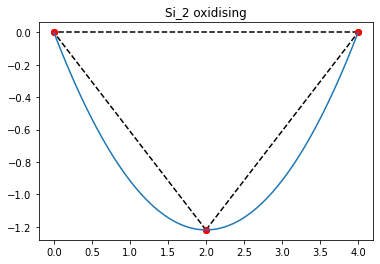

[ 3.04837599e-01 -1.21935040e+00  7.69185075e-16]
Al2_ox


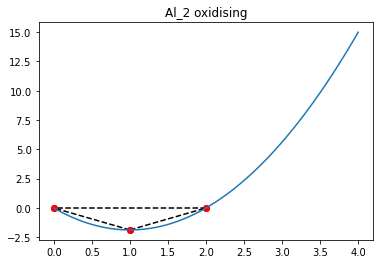

[ 1.87423147e+00 -3.74846294e+00  1.53837015e-15]
Ti2_ox


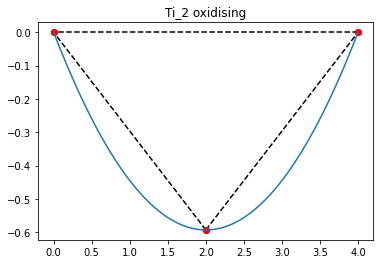

[ 1.48313003e-01 -5.93252011e-01  3.84592537e-16]
V2_ox


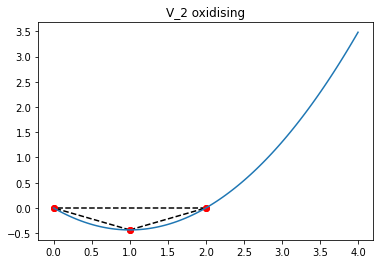

[ 4.35243869e-01 -8.70487739e-01  2.56395025e-16]
Cr2_ox


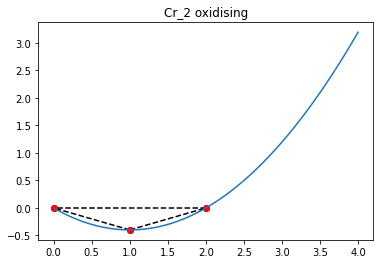

[ 3.99294889e-01 -7.98589779e-01  2.56395025e-16]
Mn2_ox


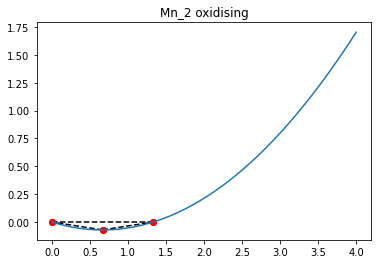

[ 1.59641041e-01 -2.12961148e-01  3.20493781e-17]
Fe2_ox


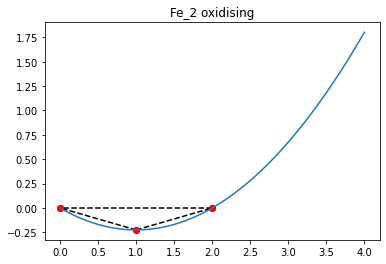

[ 2.25295649e-01 -4.50591298e-01  1.28197512e-16]
Co2_ox


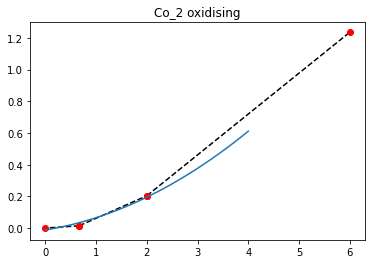

[ 0.0261293   0.05121881 -0.01161969]
Ni2_ox


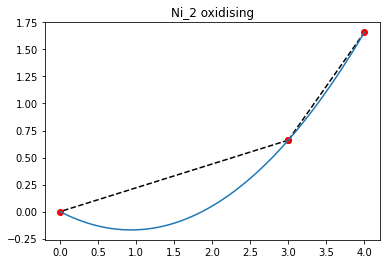

[ 1.94387121e-01 -3.62788787e-01 -1.28197512e-16]
Cu2_ox


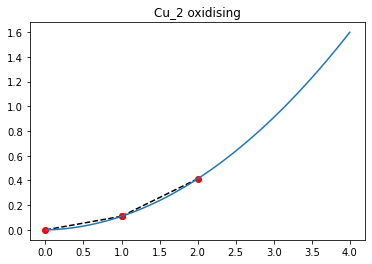

[ 9.64634363e-02  1.37517332e-02 -3.20493781e-17]
Nb2_ox


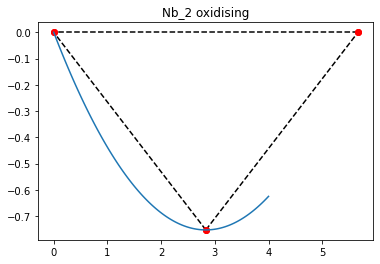

[ 9.37845352e-02 -5.31383176e-01 -5.12790050e-16]
Mo2_ox


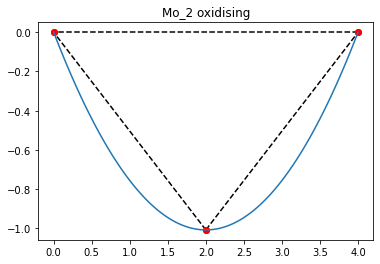

[ 2.51966798e-01 -1.00786719e+00  7.69185075e-16]
Li2_ox


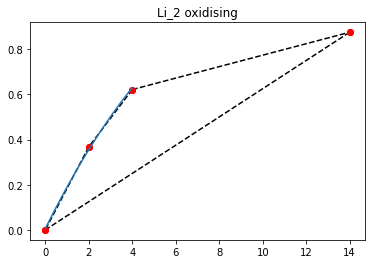

[-0.00938364  0.19348462  0.00555171]
Be2_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Na2_ox
None
Mg2_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
K2_ox


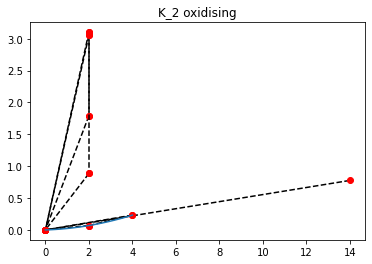

[1.17129756e-02 1.10553691e-02 8.01234453e-18]
Ca2_ox


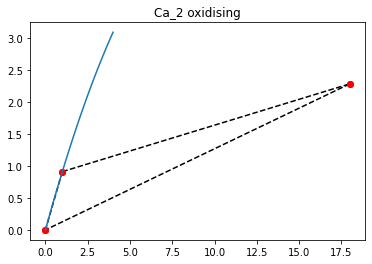

[-4.60371490e-02  9.55295226e-01 -4.10232040e-15]
Rb2_ox


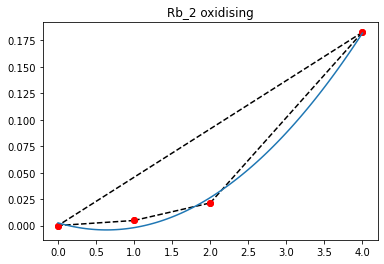

[ 0.01645138 -0.02095486  0.00253197]
Sr2_ox


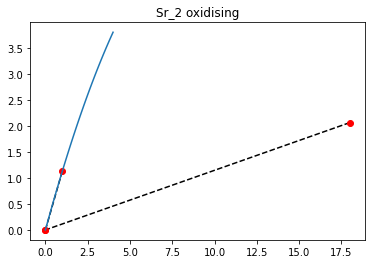

[-5.96306963e-02  1.18786879e+00 -2.05116020e-15]
Cs2_ox


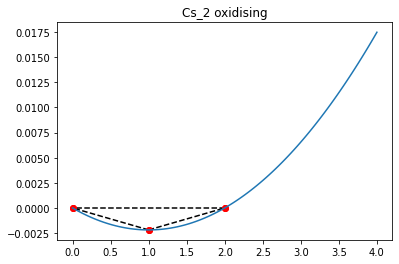

[ 2.18551121e-03 -4.37102241e-03  1.00154307e-18]
Ba2_ox


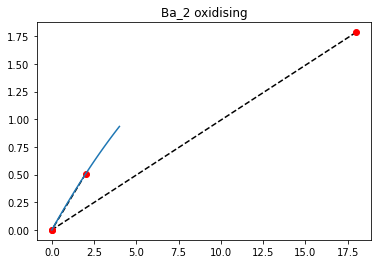

[-9.60444317e-03  2.72096875e-01 -2.56395025e-16]
Sc2_ox


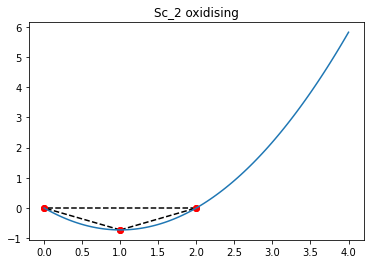

[ 7.28026875e-01 -1.45605375e+00  5.12790050e-16]
Zn2_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Ga2_ox


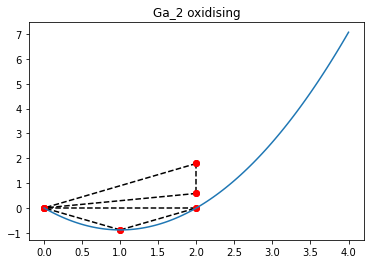

[ 8.84018072e-01 -1.76803614e+00  7.69185075e-16]
Ge2_ox


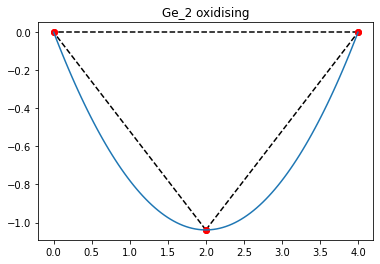

[ 2.59690564e-01 -1.03876226e+00  2.56395025e-16]
As2_ox


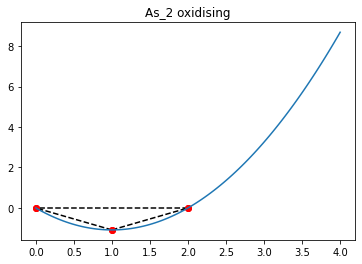

[ 1.08540237 -2.17080474  0.        ]
Se2_ox


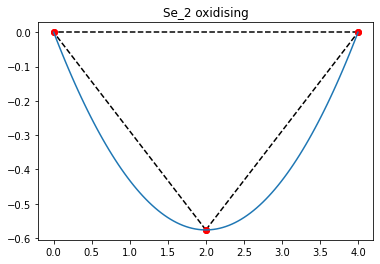

[ 1.44097670e-01 -5.76390679e-01  3.84592537e-16]
Br2_ox


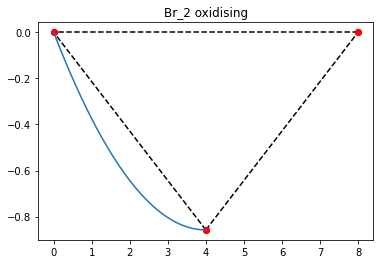

[ 5.36091330e-02 -4.28873064e-01  2.56395025e-16]
Y2_ox


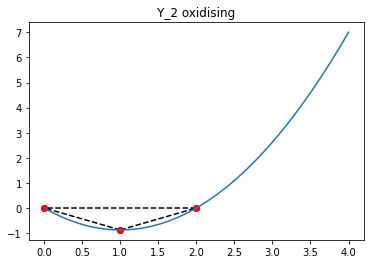

[ 8.75572871e-01 -1.75114574e+00  5.12790050e-16]
Zr2_ox


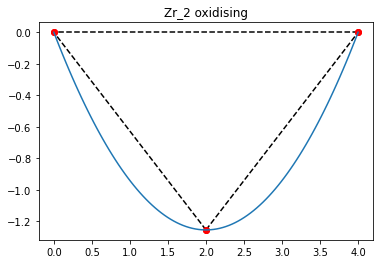

[ 3.13873614e-01 -1.25549446e+00  1.02558010e-15]
Tc2_ox


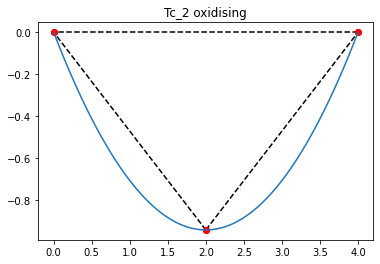

[ 2.35251386e-01 -9.41005543e-01  7.69185075e-16]
Ru2_ox


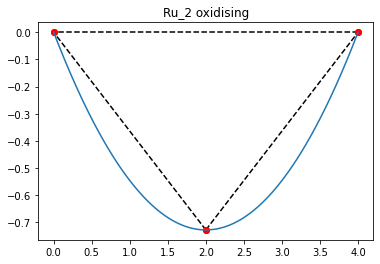

[ 1.82038326e-01 -7.28153304e-01  6.40987562e-16]
Rh2_ox


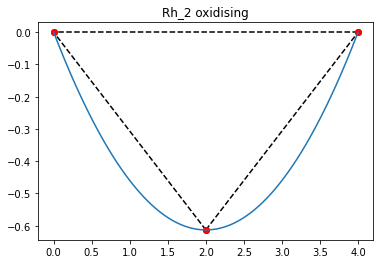

[ 1.53267421e-01 -6.13069685e-01  3.84592537e-16]
Pd2_ox
None
Ag2_ox
None
Cd2_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
In2_ox


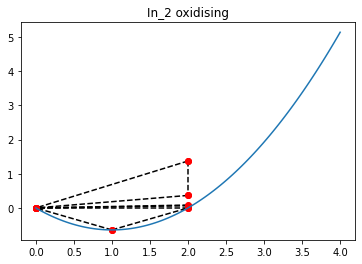

[ 6.41984749e-01 -1.28396950e+00  3.84592537e-16]
Sn2_ox


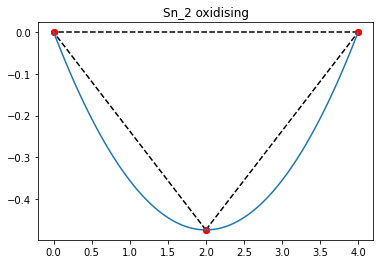

[ 1.18628605e-01 -4.74514422e-01  2.56395025e-16]
Sb2_ox


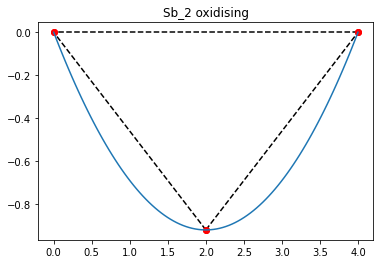

[ 2.29516591e-01 -9.18066362e-01  7.69185075e-16]
Te2_ox


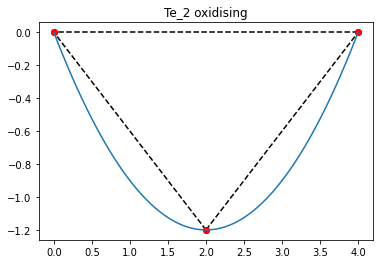

[ 2.99154013e-01 -1.19661605e+00  5.12790050e-16]
I2_ox


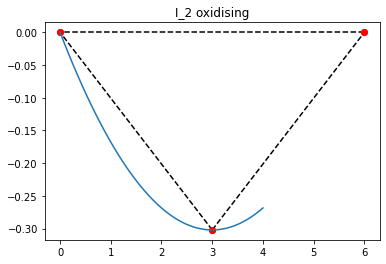

[ 3.35558513e-02 -2.01335108e-01  2.56395025e-16]
Hf2_ox


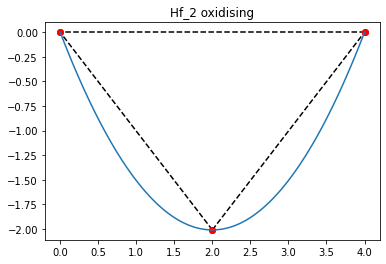

[ 5.02306641e-01 -2.00922657e+00  1.53837015e-15]
Ta2_ox


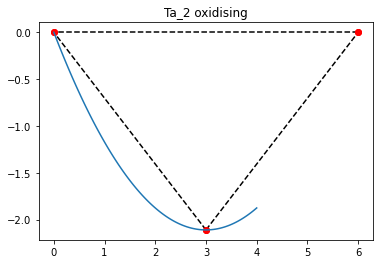

[ 2.34442842e-01 -1.40665705e+00  1.02558010e-15]
W2_ox


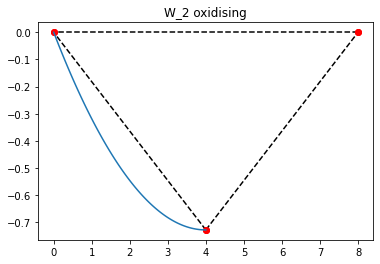

[ 4.54877825e-02 -3.63902260e-01  5.12790050e-16]
Re2_ox


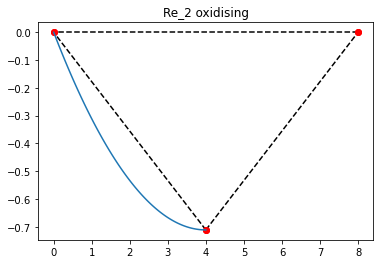

[ 4.44553440e-02 -3.55642752e-01  2.56395025e-16]
Os2_ox


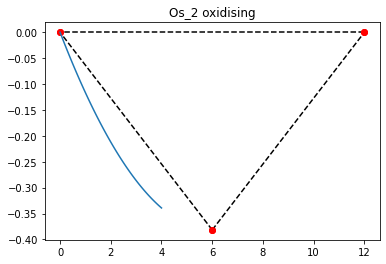

[ 1.06024822e-02 -1.27229787e-01  3.84592537e-16]
Ir2_ox


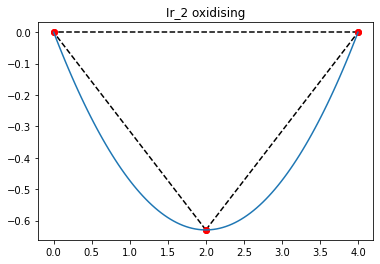

[ 1.57441846e-01 -6.29767382e-01  5.12790050e-16]
Pt2_ox


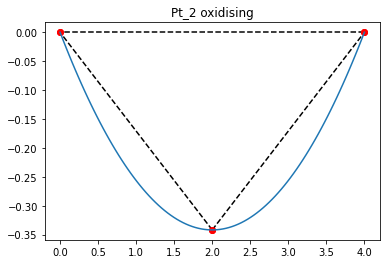

[ 8.54781921e-02 -3.41912768e-01  3.20493781e-16]
Au2_ox


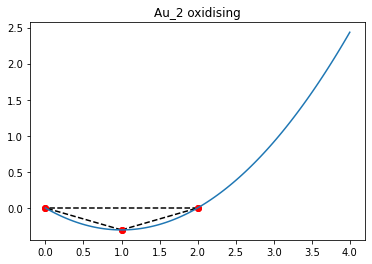

[ 3.04388371e-01 -6.08776743e-01  3.20493781e-16]
Hg2_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Tl2_ox


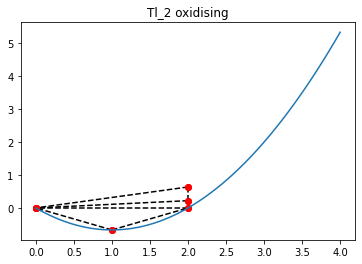

[ 6.67153616e-01 -1.33430723e+00  3.84592537e-16]
Pb2_ox


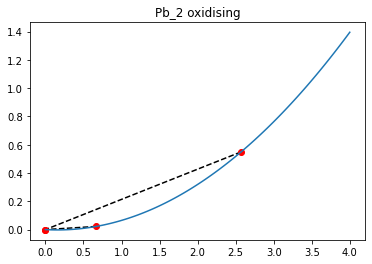

[ 9.46557993e-02 -2.97785549e-02 -2.80432058e-17]
Bi2_ox


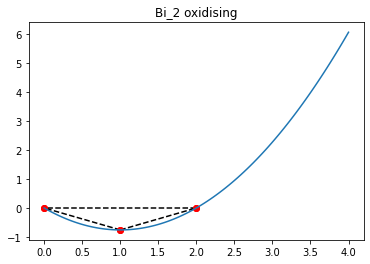

[ 7.58539625e-01 -1.51707925e+00  6.40987562e-16]
La2_ox


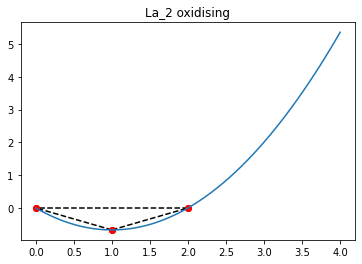

[ 6.69590564e-01 -1.33918113e+00  5.12790050e-16]
Ce2_ox


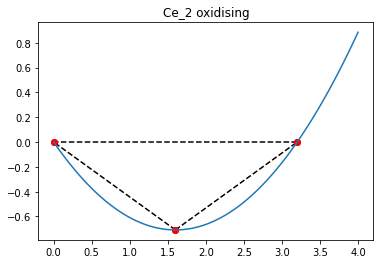

[ 2.76691107e-01 -8.85411543e-01 -1.28197512e-16]
Nd2_ox


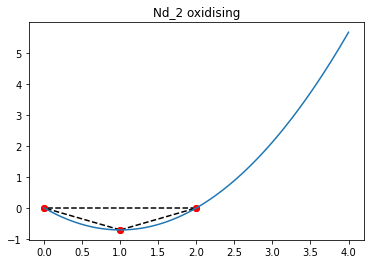

[ 7.08010668e-01 -1.41602134e+00  2.56395025e-16]
Pr2_ox


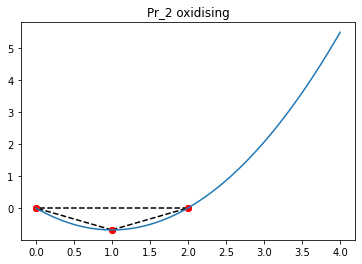

[ 6.88595320e-01 -1.37719064e+00  5.12790050e-16]
Sm2_ox


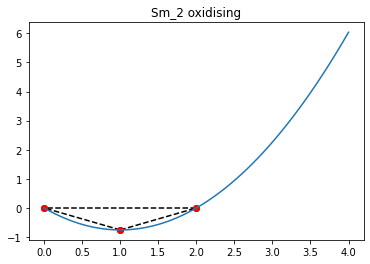

[ 7.54493077e-01 -1.50898615e+00  5.12790050e-16]
Eu2_ox


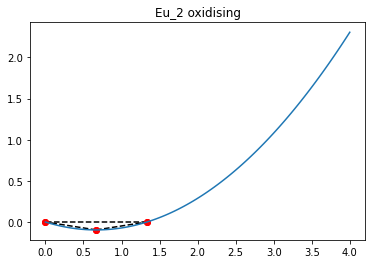

[ 2.16146195e-01 -2.88339024e-01  6.40987562e-17]
Gd2_ox


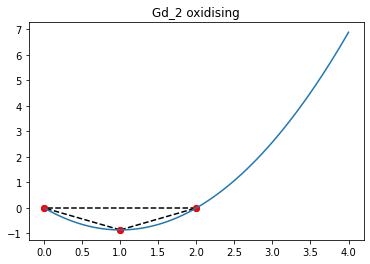

[ 8.60110064e-01 -1.72022013e+00  5.12790050e-16]
Tb2_ox


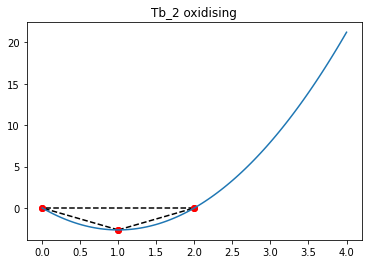

[ 2.65490302e+00 -5.30980604e+00  3.07674030e-15]
Dy2_ox


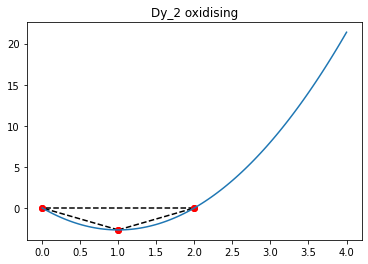

[ 2.67230524e+00 -5.34461048e+00  2.05116020e-15]
Ho2_ox


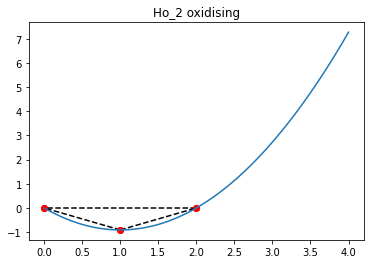

[ 9.09040716e-01 -1.81808143e+00  5.12790050e-16]
Er2_ox


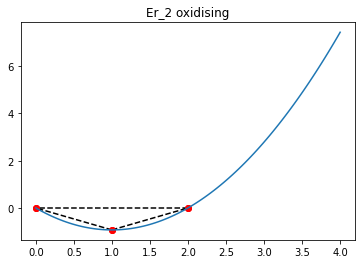

[ 9.29290143e-01 -1.85858029e+00  7.69185075e-16]
Tm2_ox


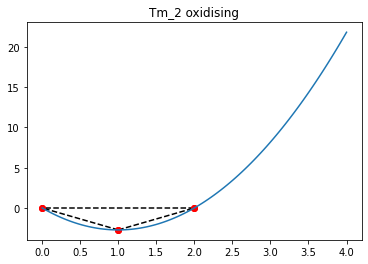

[ 2.72787951e+00 -5.45575902e+00  3.07674030e-15]
Yb2_ox


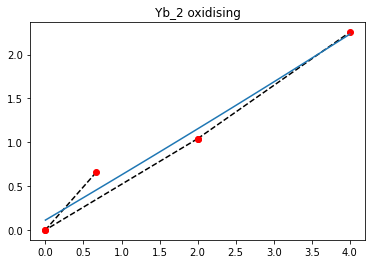

[0.00490275 0.51050194 0.11223342]
Lu2_ox


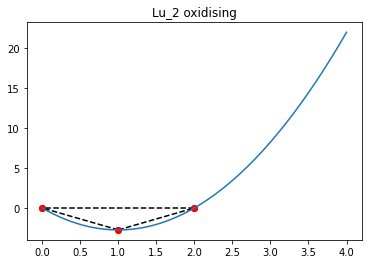

[ 2.74856996e+00 -5.49713993e+00  1.53837015e-15]
Si2_red
Al2_red


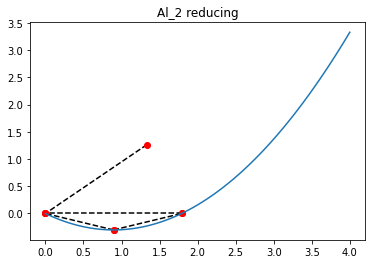

Ti2_red


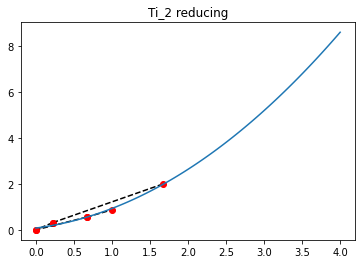

V2_red
Cr2_red
Mn2_red
Mn  odd.


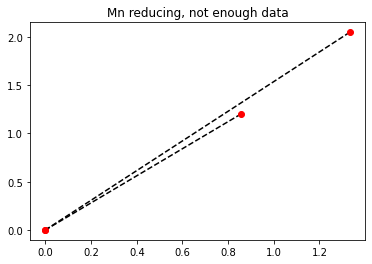

Fe2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Co2_red
Co  odd.


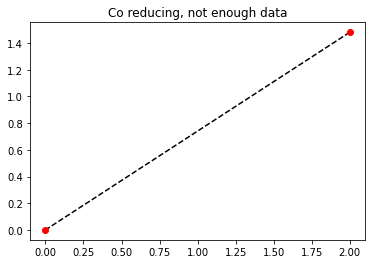

Ni2_red


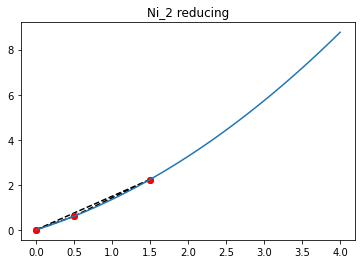

Cu2_red
Nb2_red
Nb  odd.


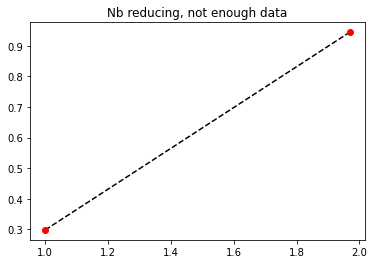

Mo2_red
Mo  odd.


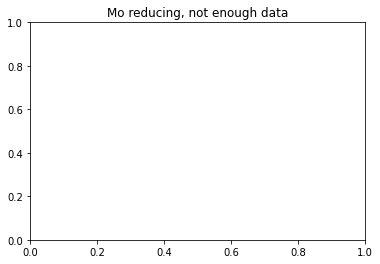

Li2_red


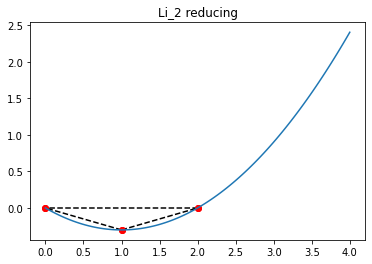

Be2_red
Be  odd.


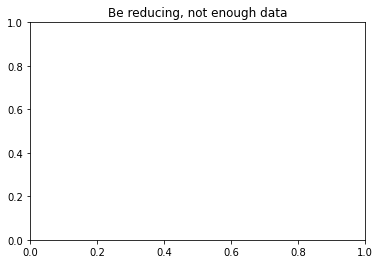

Na2_red


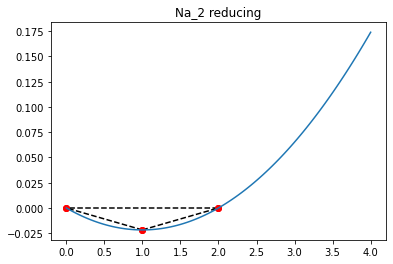

Mg2_red
Mg  odd.


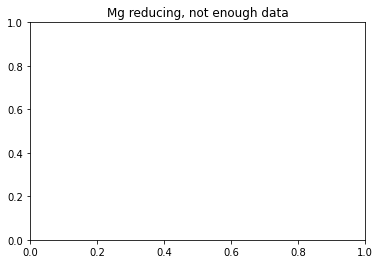

K2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


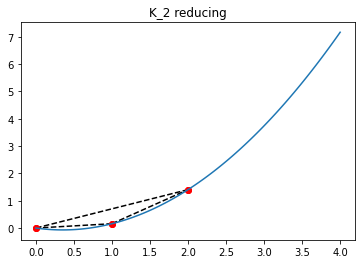

Ca2_red
Ca  odd.


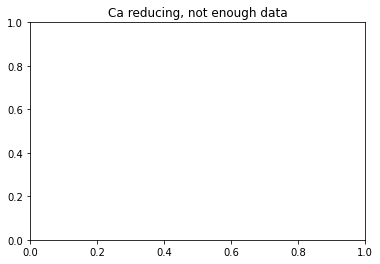

Rb2_red


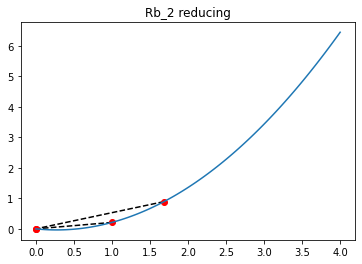

Sr2_red
Sr  odd.


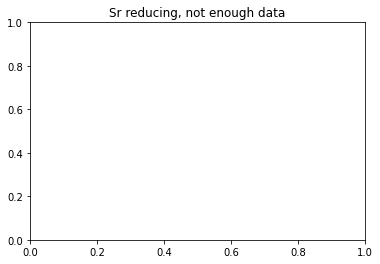

Cs2_red


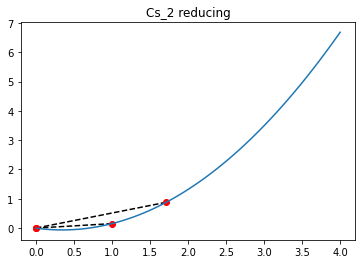

Ba2_red
Ba  odd.


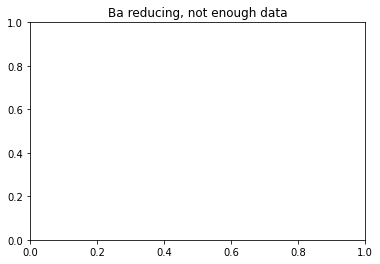

Sc2_red
Zn2_red
Zn  odd.


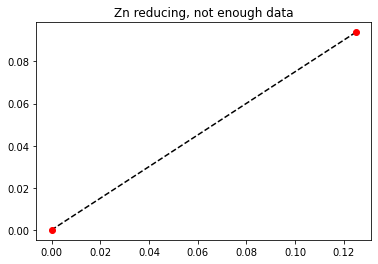

Ga2_red
Ga  odd.


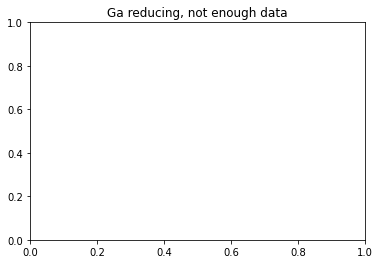

Ge2_red
Ge  odd.


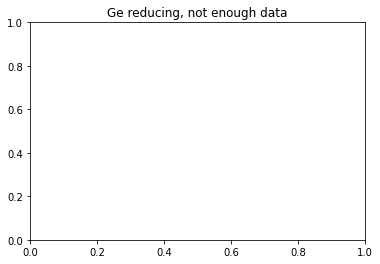

As2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
As  odd.


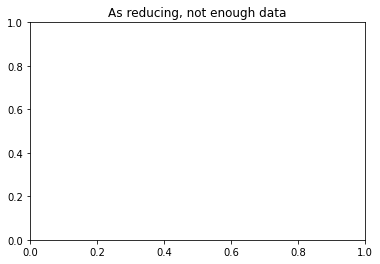

Se2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Se  odd.


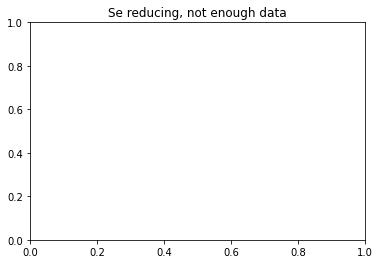

Br2_red


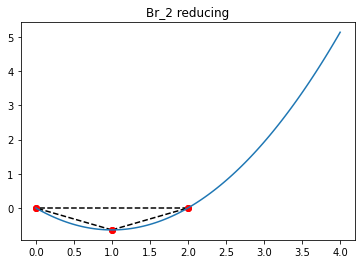

Y2_red
Y  odd.


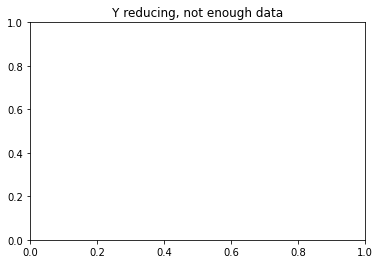

Zr2_red
Tc2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tc  odd.


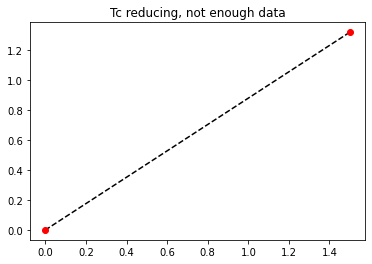

Ru2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ru  odd.


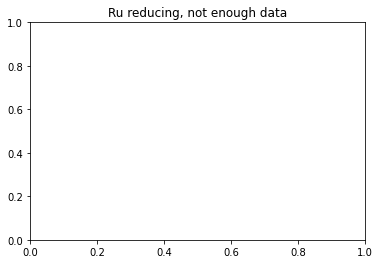

Rh2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Rh  odd.


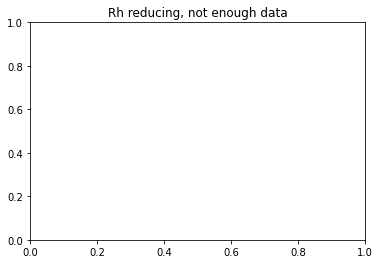

Pd2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ag2_red
Cd2_red
Cd  odd.


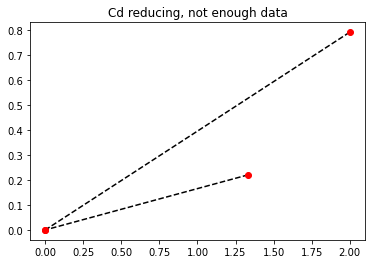

In2_red
In  odd.


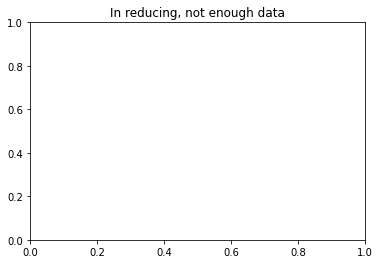

Sn2_red
Sn  odd.


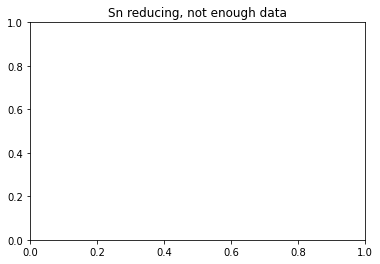

Sb2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Sb  odd.


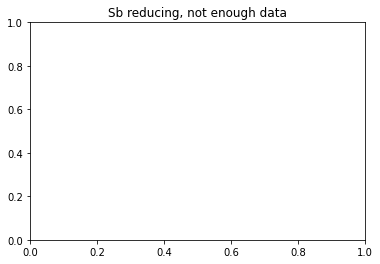

Te2_red
Te  odd.


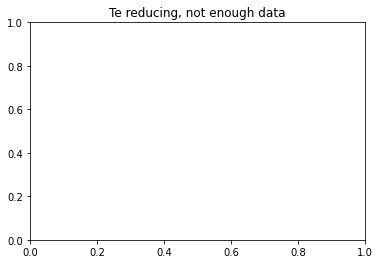

I2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
I  odd.


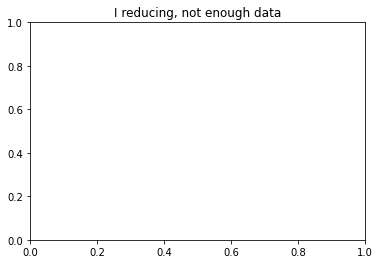

Hf2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Hf  odd.


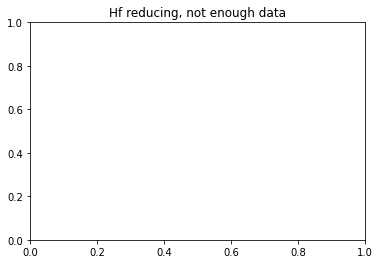

Ta2_red


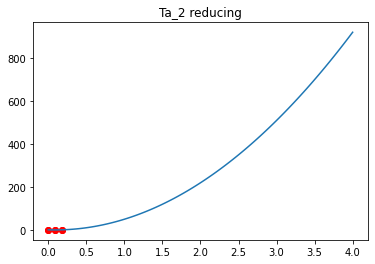

W2_red
W  odd.


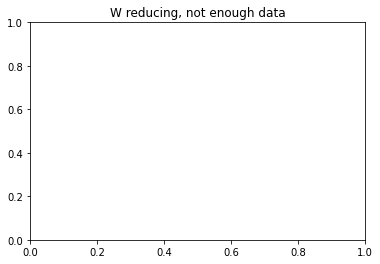

Re2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Re  odd.


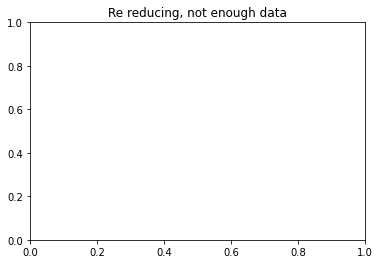

Os2_red
Os  odd.


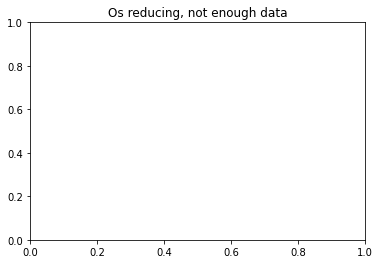

Ir2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ir  odd.


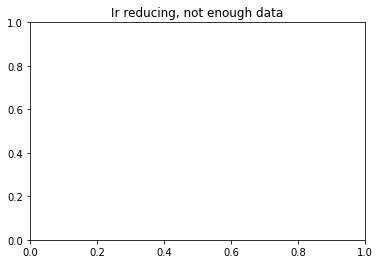

Pt2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Au2_red
Au  odd.


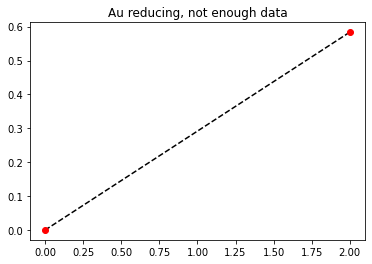

Hg2_red
Hg  odd.


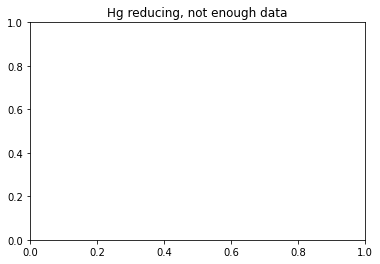

Tl2_red


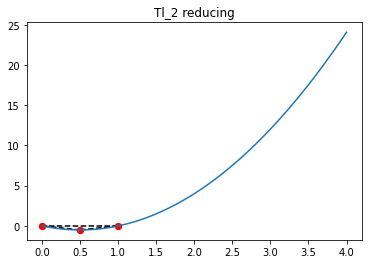

Pb2_red
Bi2_red


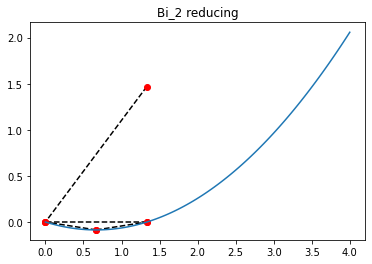

La2_red
La  odd.


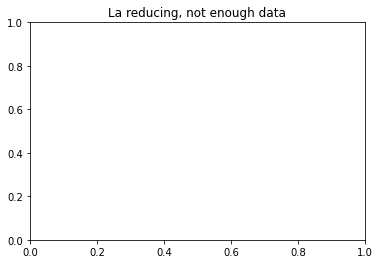

Ce2_red
Ce  odd.


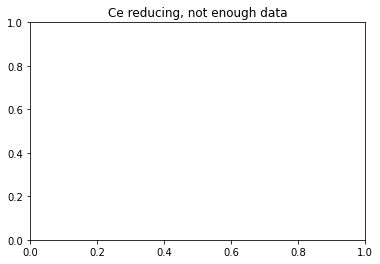

Nd2_red
Nd  odd.


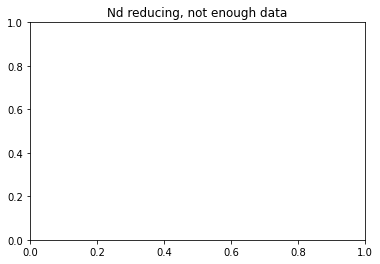

Pr2_red
Pr  odd.


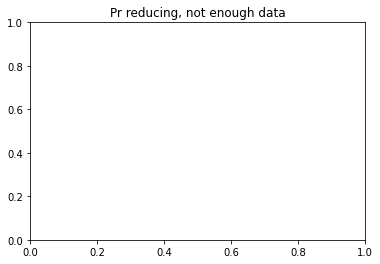

Sm2_red
Eu2_red
Eu  odd.


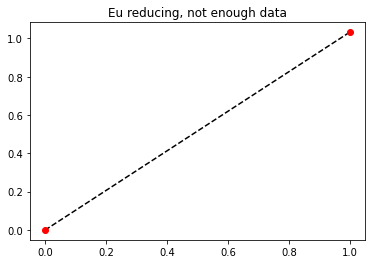

Gd2_red
Gd  odd.


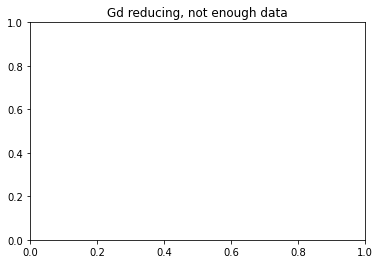

Tb2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tb  odd.


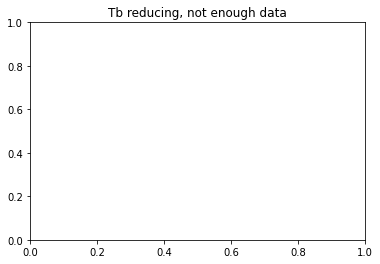

Dy2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Dy  odd.


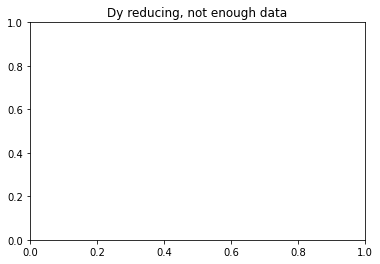

Ho2_red
Ho  odd.


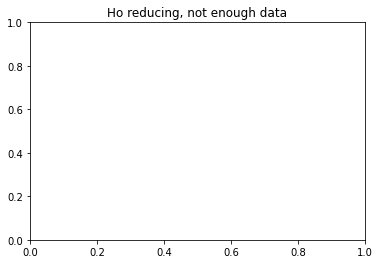

Er2_red
Er  odd.


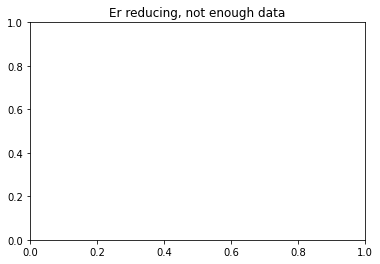

Tm2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tm  odd.


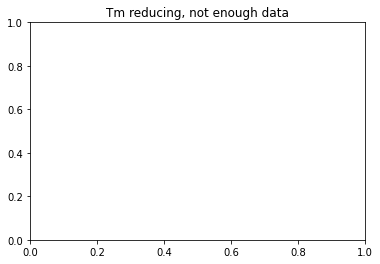

Yb2_red
Yb  odd.


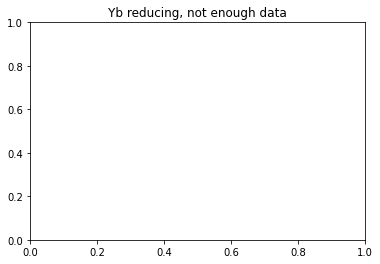

Lu2_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Lu  odd.


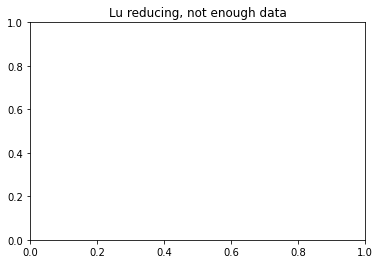

Si3_ox


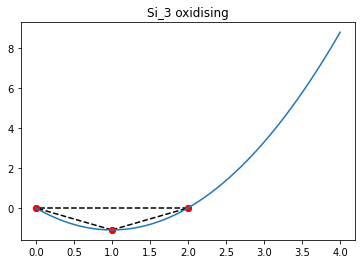

[ 1.10154323e+00 -2.20308646e+00  1.02558010e-15]
Al3_ox


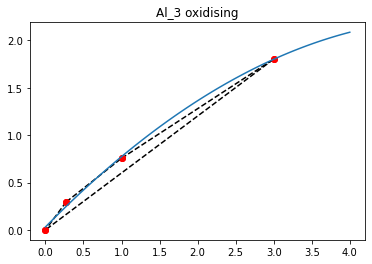

[-0.07616322  0.81819359  0.0307375 ]
Ti3_ox


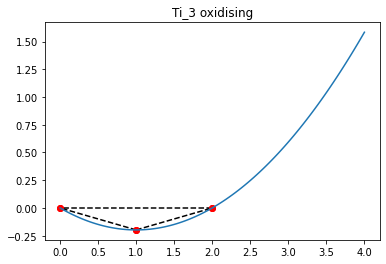

[ 1.98016473e-01 -3.96032946e-01  6.40987562e-17]
V3_ox


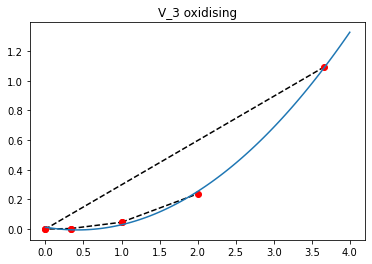

[ 0.10404092 -0.08760764  0.01264585]
Cr3_ox


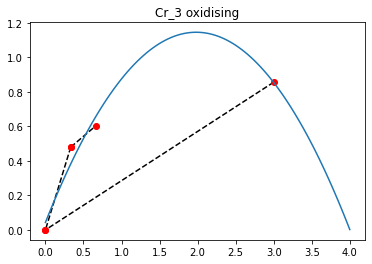

[-0.28058031  1.11200669  0.04334187]
Mn3_ox


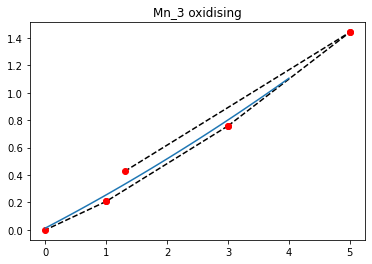

[0.01026593 0.23186837 0.01386559]
Fe3_ox
None
Co3_ox


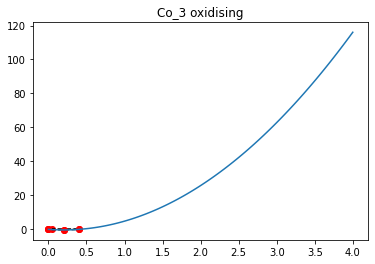

[ 8.05833955e+00 -3.22333582e+00  2.56395025e-16]
Ni3_ox


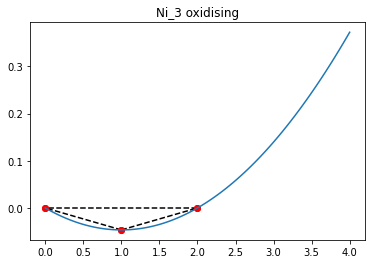

[ 4.65629443e-02 -9.31258887e-02  3.20493781e-17]
Cu3_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


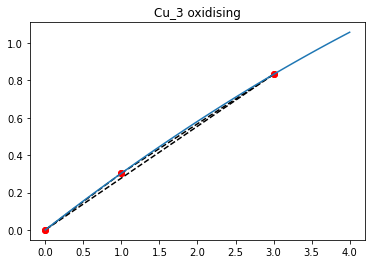

[-1.29776418e-02  3.16119684e-01  2.56395025e-16]
Nb3_ox


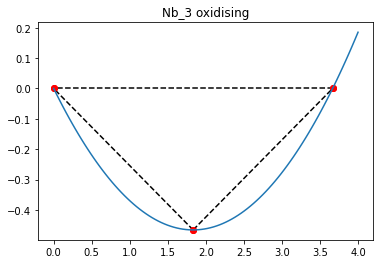

[ 1.38737012e-01 -5.08609886e-01 -1.28197512e-16]
Mo3_ox


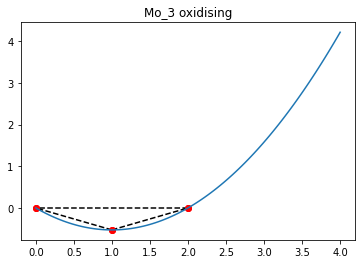

[ 5.26624134e-01 -1.05324827e+00  3.84592537e-16]
Li3_ox


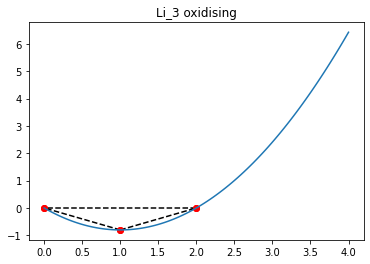

[ 8.03376599e-01 -1.60675320e+00  5.12790050e-16]
Be3_ox


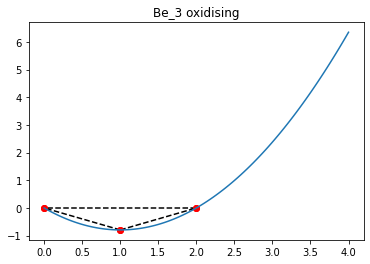

[ 7.93589902e-01 -1.58717981e+00  5.12790050e-16]
Na3_ox


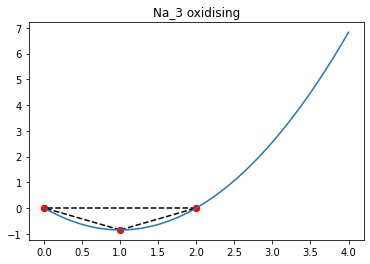

[ 8.54076034e-01 -1.70815207e+00  5.12790050e-16]
Mg3_ox


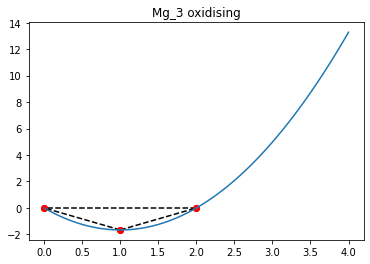

[ 1.65951576e+00 -3.31903152e+00  1.53837015e-15]
K3_ox


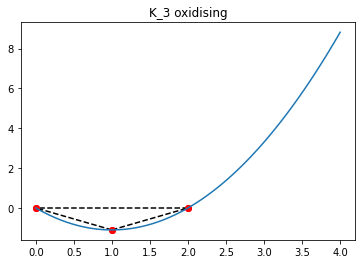

[ 1.10222156e+00 -2.20444312e+00  7.69185075e-16]
Ca3_ox


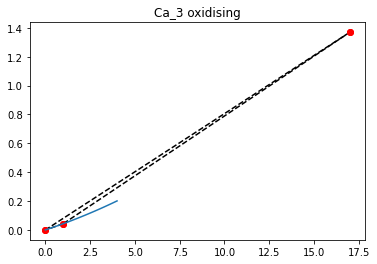

[2.33443362e-03 4.09040247e-02 9.61481343e-17]
Rb3_ox


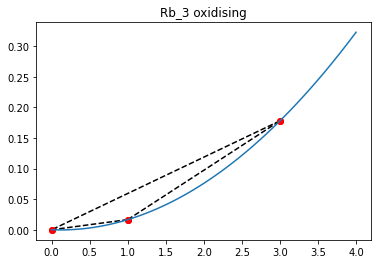

[ 2.13746497e-02 -4.79122450e-03  2.30354905e-17]
Sr3_ox


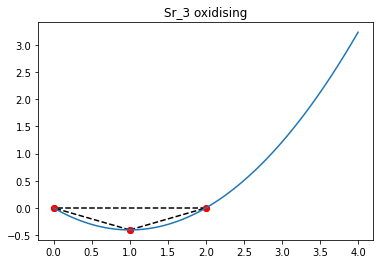

[ 4.04234707e-01 -8.08469414e-01  2.56395025e-16]
Cs3_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


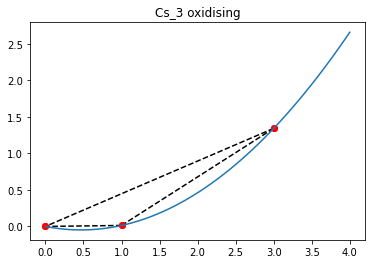

[ 2.17036778e-01 -2.03569730e-01  1.60246891e-16]
Ba3_ox


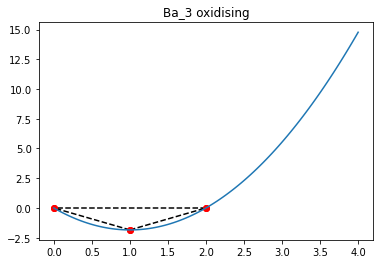

[ 1.84639959e+00 -3.69279918e+00  5.12790050e-16]
Sc3_ox


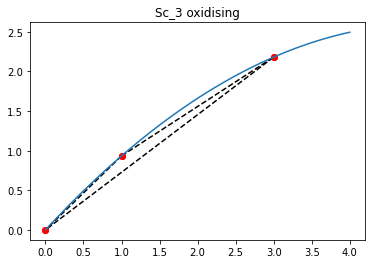

[-1.03343130e-01  1.03719813e+00  7.69185075e-16]
Zn3_ox


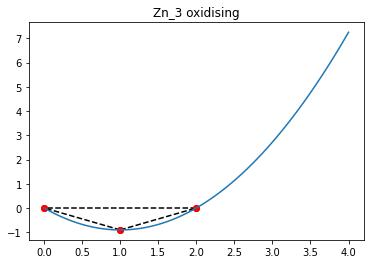

[ 9.06845881e-01 -1.81369176e+00  5.12790050e-16]
Ga3_ox


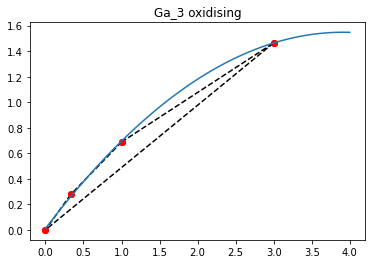

[-0.1003681   0.78576452  0.01008525]
Ge3_ox


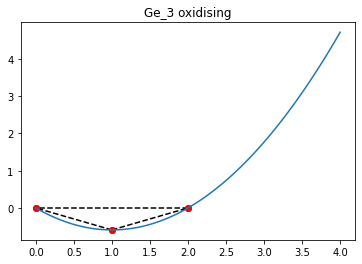

[ 5.89644449e-01 -1.17928890e+00  5.12790050e-16]
As3_ox


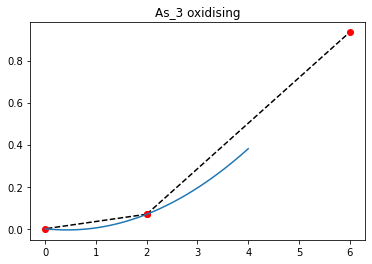

[ 3.03177364e-02 -2.61227204e-02 -6.40987562e-17]
Se3_ox


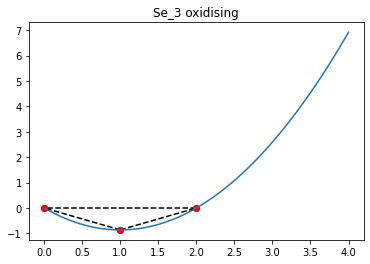

[ 8.64586019e-01 -1.72917204e+00  7.69185075e-16]
Br3_ox


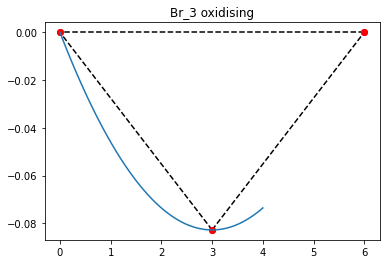

[ 9.19341958e-03 -5.51605175e-02  8.01234453e-17]
Y3_ox


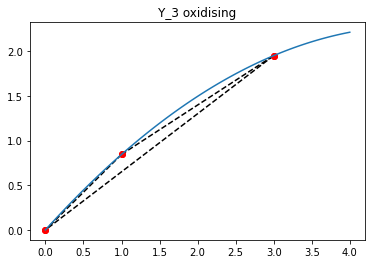

[-9.71378114e-02  9.41477847e-01  5.12790050e-16]
Zr3_ox


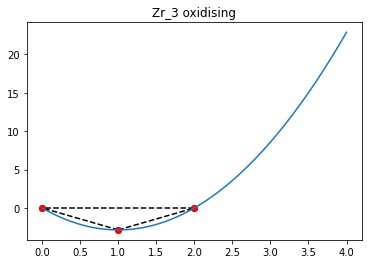

[ 2.85919102e+00 -5.71838203e+00  3.07674030e-15]
Tc3_ox


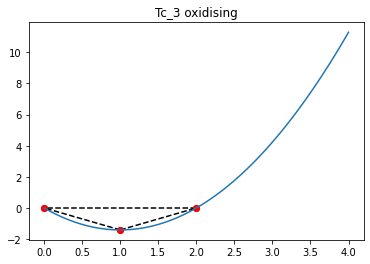

[ 1.41150832e+00 -2.82301663e+00  1.28197512e-15]
Ru3_ox


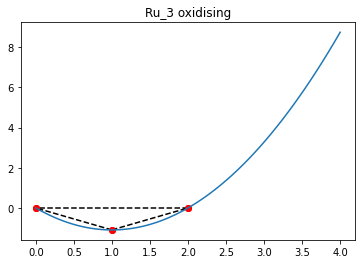

[ 1.09222996e+00 -2.18445991e+00  7.69185075e-16]
Rh3_ox


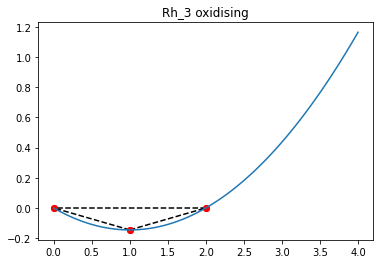

[ 1.45622200e-01 -2.91244399e-01  9.61481343e-17]
Pd3_ox


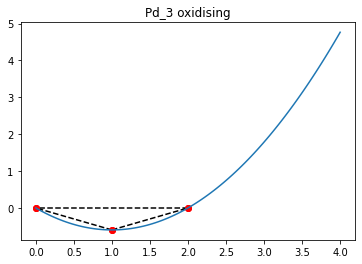

[ 5.95550041e-01 -1.19110008e+00  2.56395025e-16]
Ag3_ox


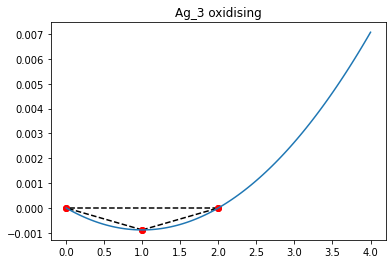

[ 8.84014611e-04 -1.76802922e-03  5.00771533e-19]
Cd3_ox


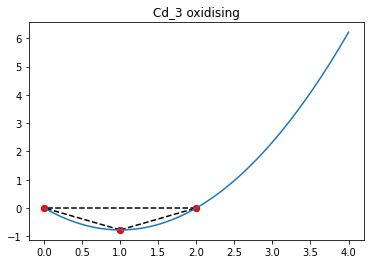

[ 7.77096693e-01 -1.55419339e+00  7.69185075e-16]
In3_ox


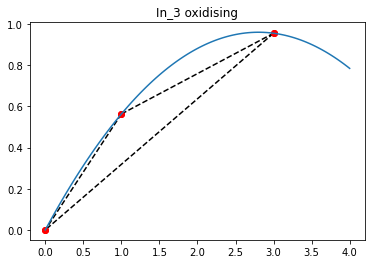

[-1.22320801e-01  6.85488701e-01  5.12790050e-16]
Sn3_ox


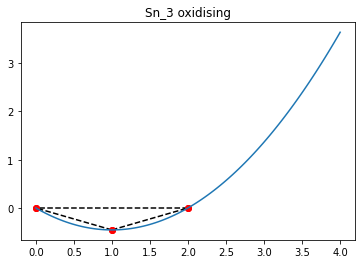

[ 4.5538234e-01 -9.1076468e-01  5.1279005e-16]
Sb3_ox


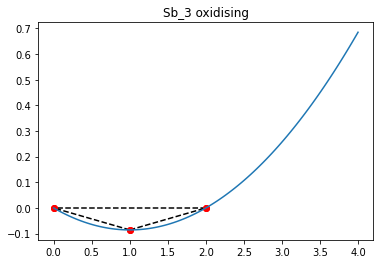

[ 8.56245926e-02 -1.71249185e-01  6.40987562e-17]
Te3_ox


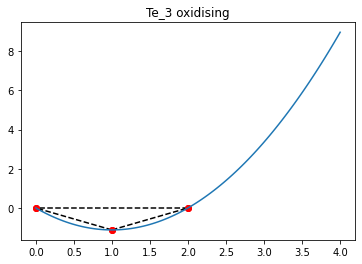

[ 1.12000625e+00 -2.24001250e+00  1.02558010e-15]
I3_ox


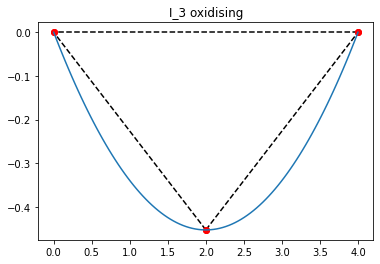

[ 1.13250998e-01 -4.53003993e-01  3.84592537e-16]
Hf3_ox


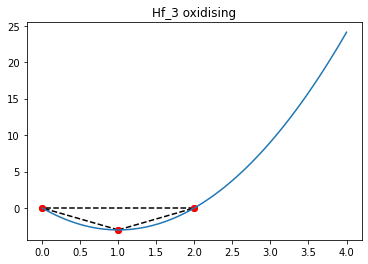

[ 3.01383985e+00 -6.02767970e+00  2.05116020e-15]
Ta3_ox


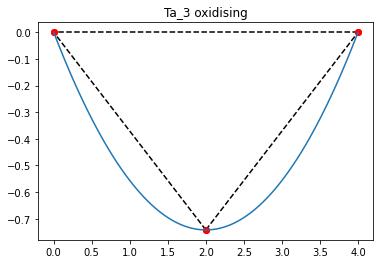

[ 1.85513887e-01 -7.42055548e-01  5.12790050e-16]
W3_ox


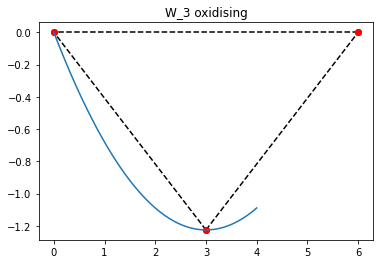

[ 1.36115669e-01 -8.16694011e-01  7.69185075e-16]
Re3_ox


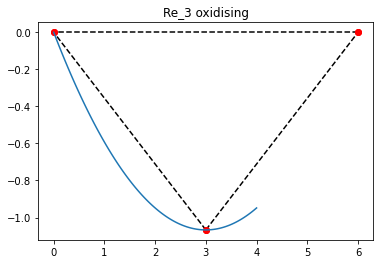

[ 1.18547584e-01 -7.11285505e-01  2.56395025e-16]
Os3_ox


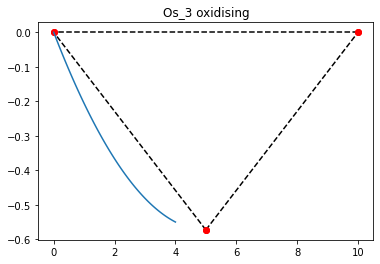

[ 2.29013616e-02 -2.29013616e-01  5.12790050e-16]
Ir3_ox


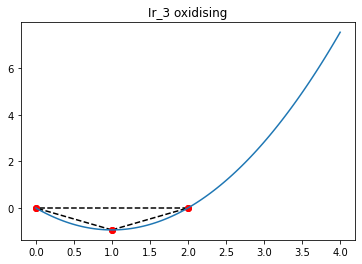

[ 9.44651074e-01 -1.88930215e+00  5.12790050e-16]
Pt3_ox


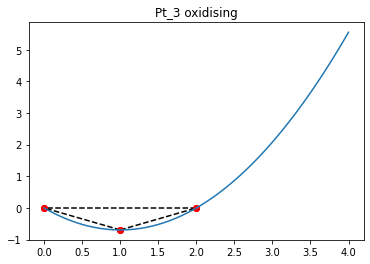

[ 6.93985221e-01 -1.38797044e+00  2.56395025e-16]
Au3_ox
Au  odd.


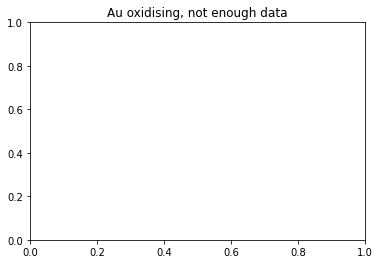

Hg3_ox


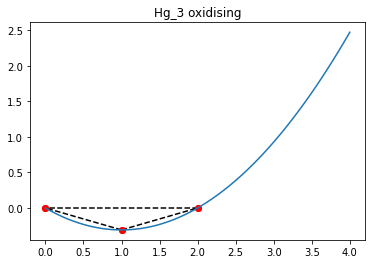

[ 3.09227979e-01 -6.18455957e-01  1.92296269e-16]
Tl3_ox
Tl  odd.


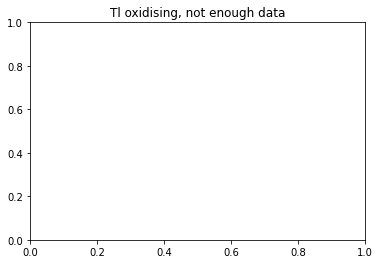

Pb3_ox


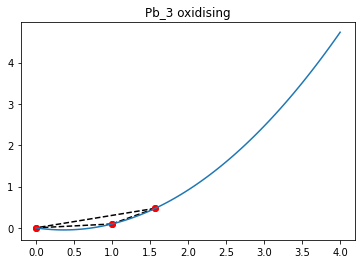

[ 3.63141336e-01 -2.69303953e-01  6.40987562e-17]
Bi3_ox


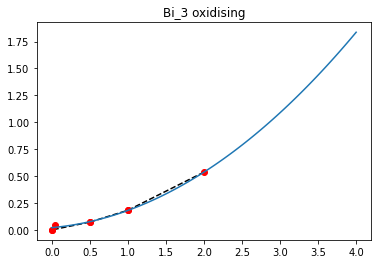

[0.09796192 0.06199897 0.02126149]
La3_ox


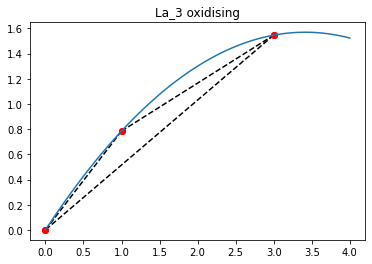

[-1.34560990e-01  9.18913726e-01  7.69185075e-16]
Ce3_ox


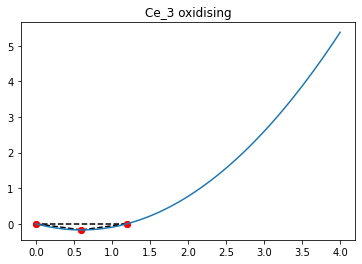

[ 4.80276160e-01 -5.76331392e-01  1.28197512e-16]
Nd3_ox


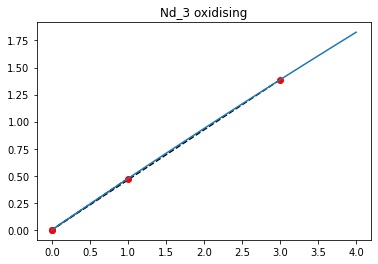

[-5.86474679e-03  4.79891672e-01  4.48691293e-16]
Pr3_ox


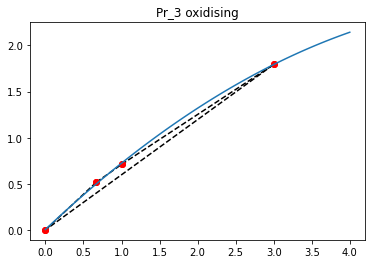

[-0.06143665  0.78033606  0.00465986]
Sm3_ox


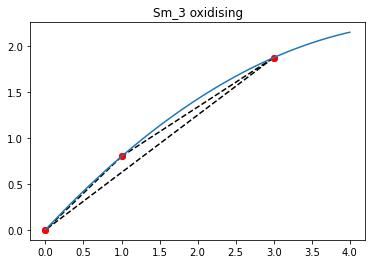

[-8.72297768e-02  8.87139244e-01  3.84592537e-16]
Eu3_ox


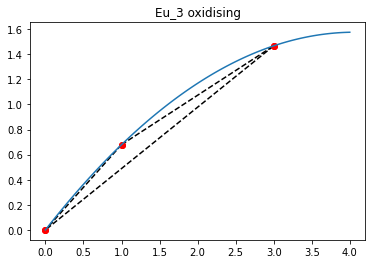

[-9.52022453e-02  7.74801485e-01  5.12790050e-16]
Gd3_ox


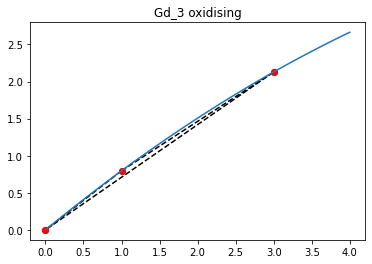

[-4.35820648e-02  8.40515504e-01  7.69185075e-16]
Tb3_ox


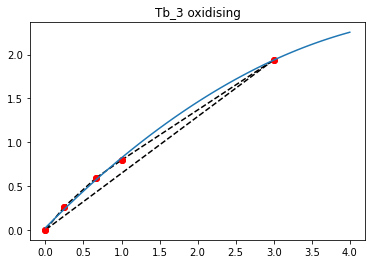

[-0.07992875  0.87722191  0.02407942]
Dy3_ox


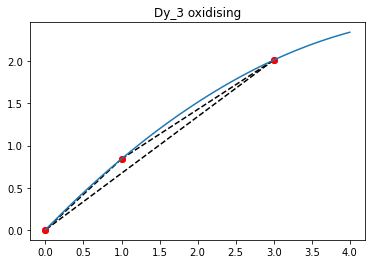

[-8.53240618e-02  9.27084111e-01  8.97382587e-16]
Ho3_ox


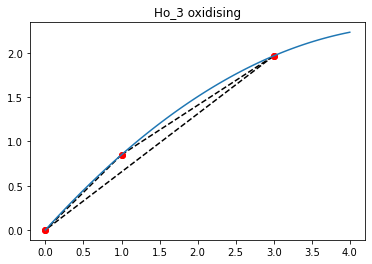

[-9.71685630e-02  9.47314204e-01  6.40987562e-16]
Er3_ox


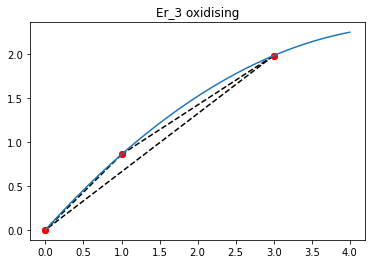

[-9.86973623e-02  9.56193321e-01  7.69185075e-16]
Tm3_ox


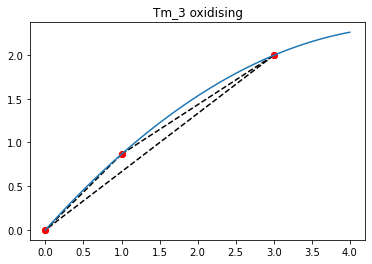

[-1.00297764e-01  9.66494969e-01  8.97382587e-16]
Yb3_ox


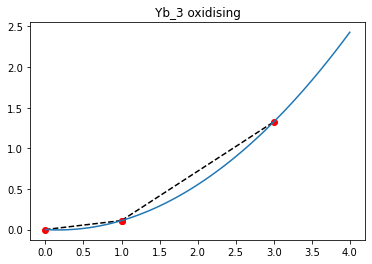

[ 1.65633779e-01 -5.52278197e-02 -4.80740672e-17]
Lu3_ox


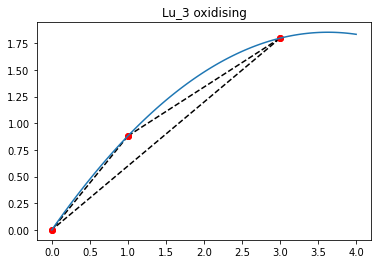

[-1.40672694e-01  1.02099093e+00  8.97382587e-16]
Si3_red


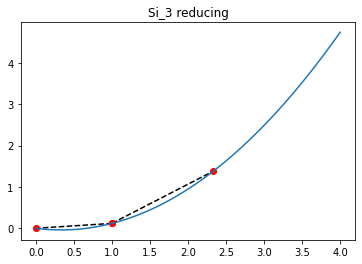

Al3_red


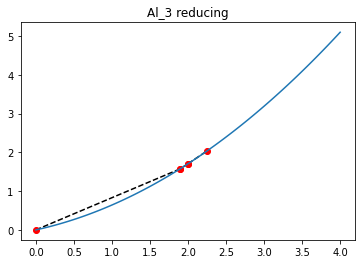

Ti3_red


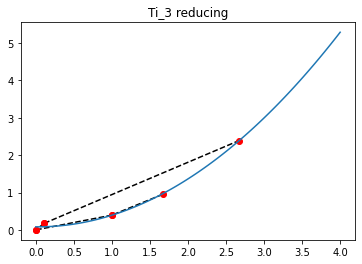

V3_red


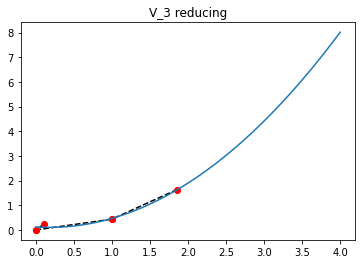

Cr3_red


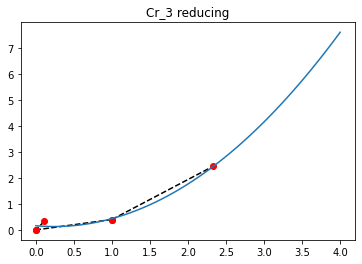

Mn3_red


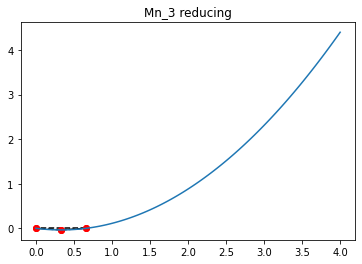

Fe3_red


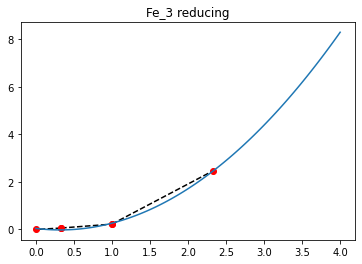

Co3_red


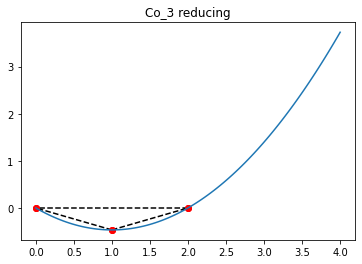

Ni3_red


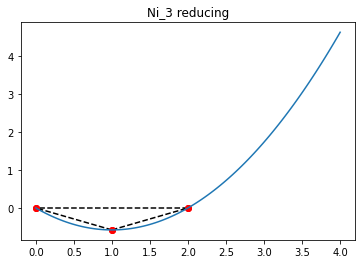

Cu3_red


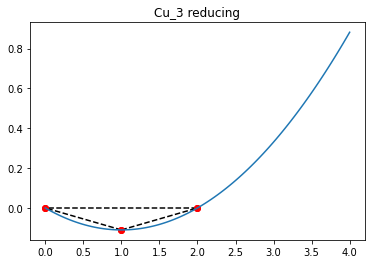

Nb3_red


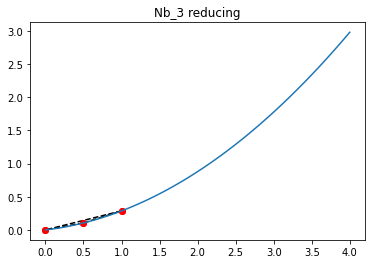

Mo3_red


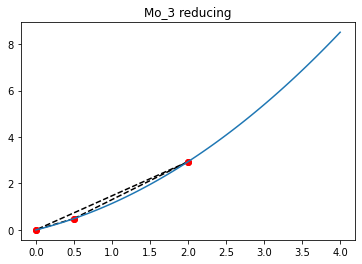

Li3_red


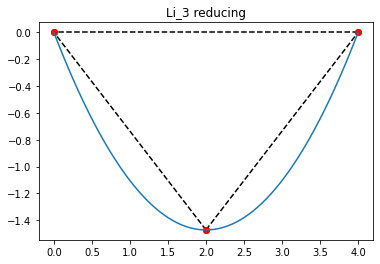

Be3_red


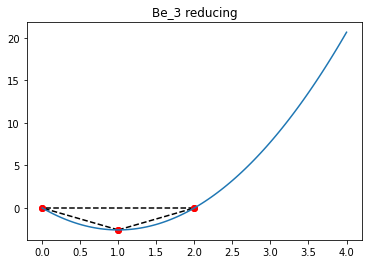

Na3_red


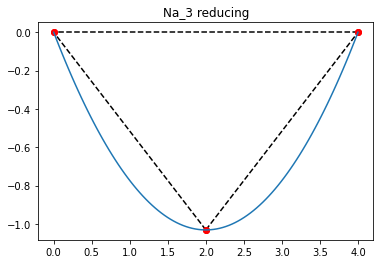

Mg3_red


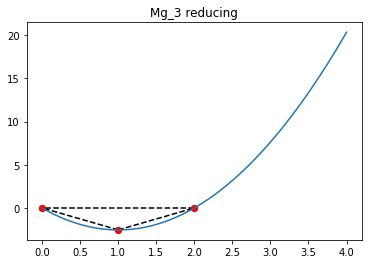

K3_red


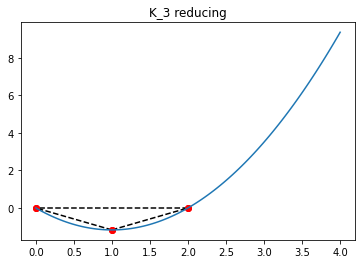

Ca3_red


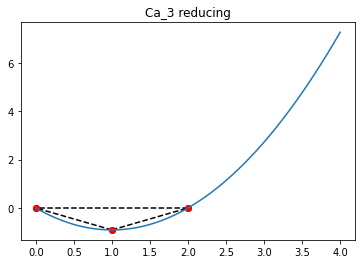

Rb3_red


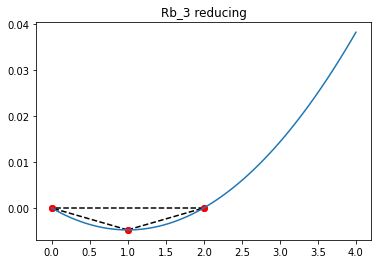

Sr3_red


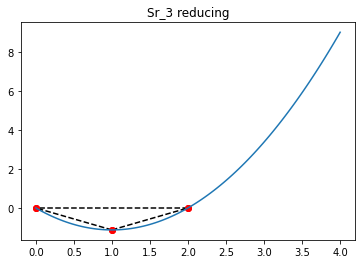

Cs3_red


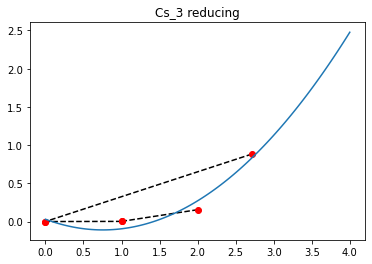

Ba3_red


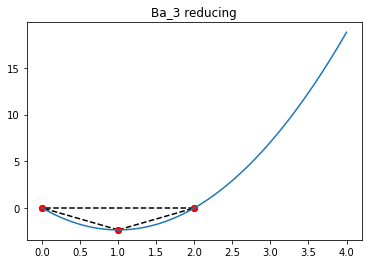

Sc3_red
Zn3_red


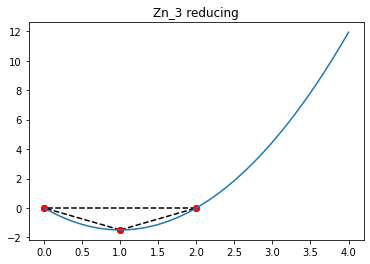

Ga3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


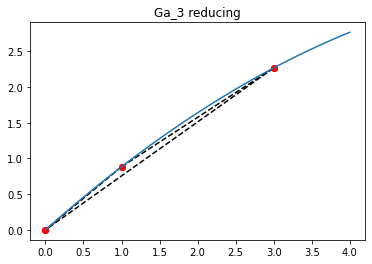

Ge3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
As3_red
As  odd.


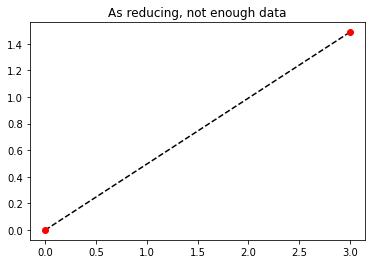

Se3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Se  odd.


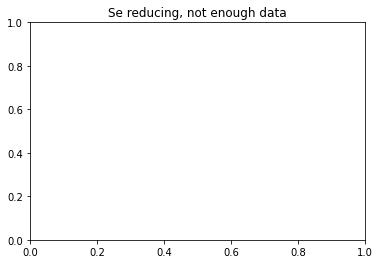

Br3_red
Y3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


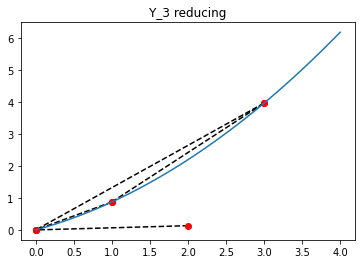

Zr3_red


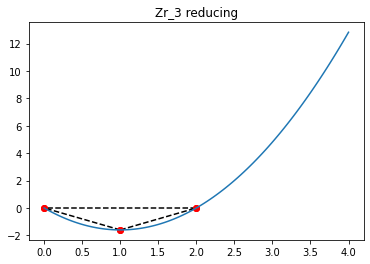

Tc3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tc  odd.


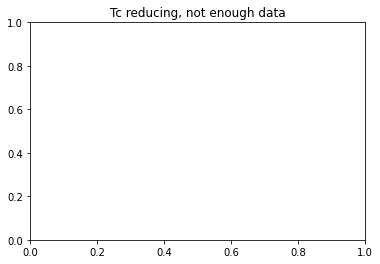

Ru3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ru  odd.


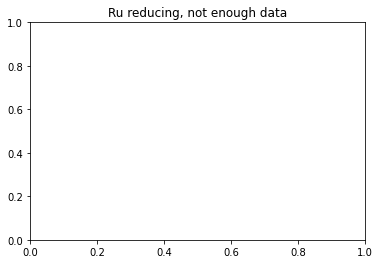

Rh3_red
Rh  odd.


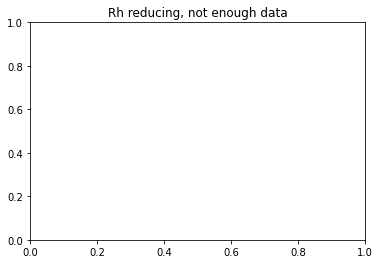

Pd3_red


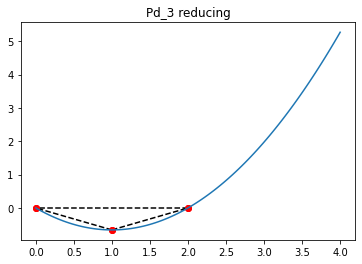

Ag3_red


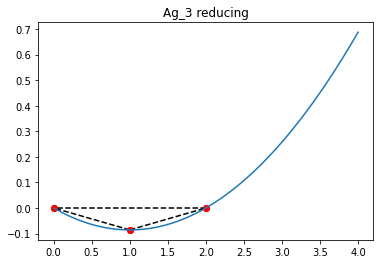

Cd3_red


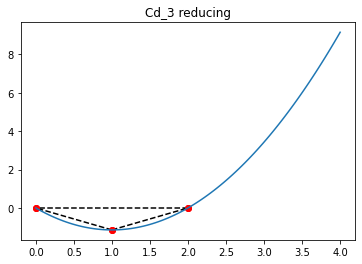

In3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


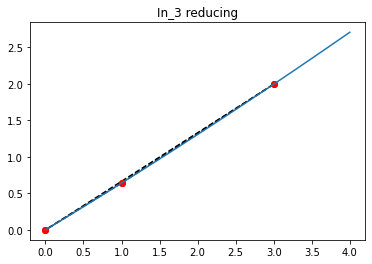

Sn3_red


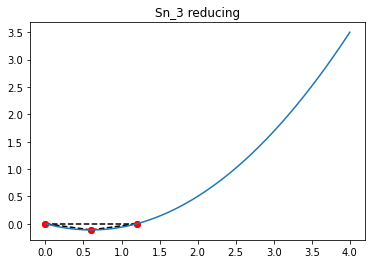

Sb3_red
Sb  odd.


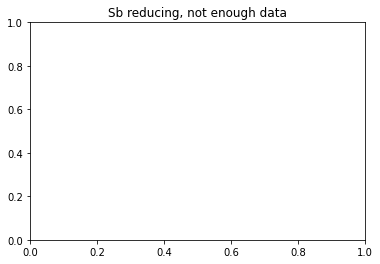

Te3_red
Te  odd.


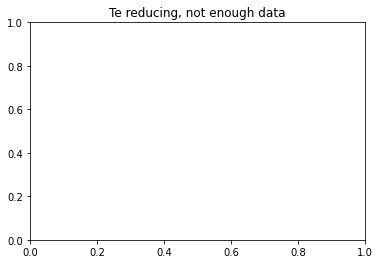

I3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
I  odd.


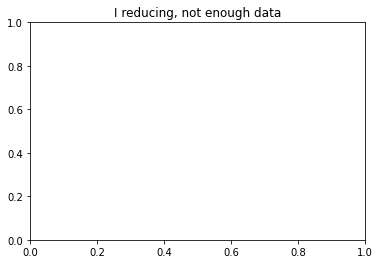

Hf3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Hf  odd.


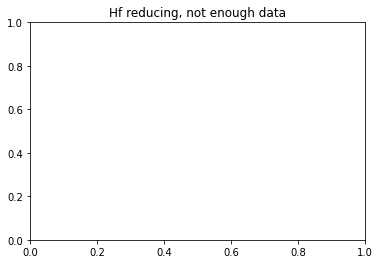

Ta3_red


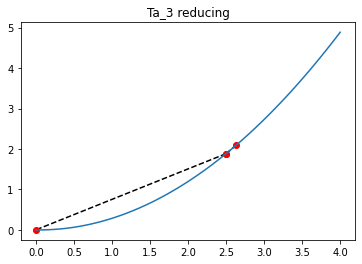

W3_red


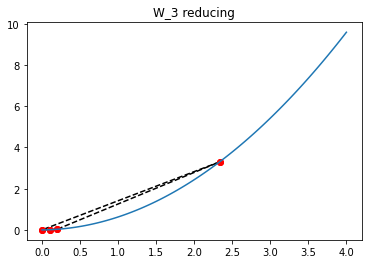

Re3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Re  odd.


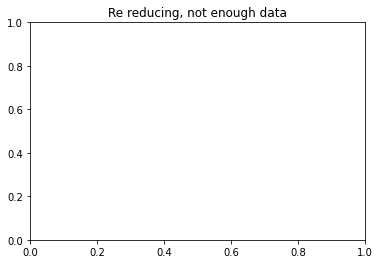

Os3_red
Os  odd.


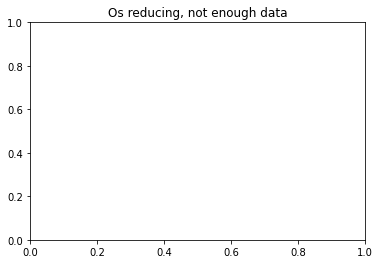

Ir3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ir  odd.


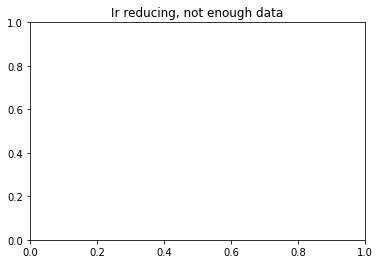

Pt3_red


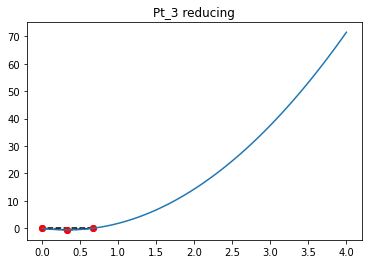

Au3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Hg3_red


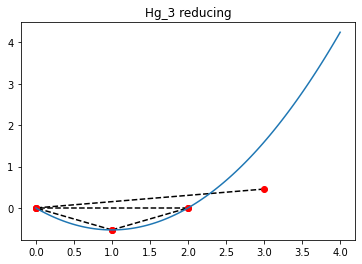

Tl3_red


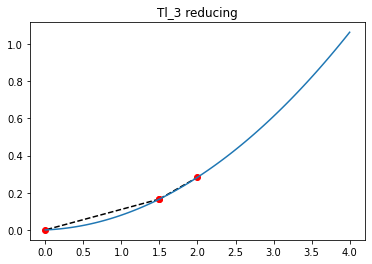

Pb3_red


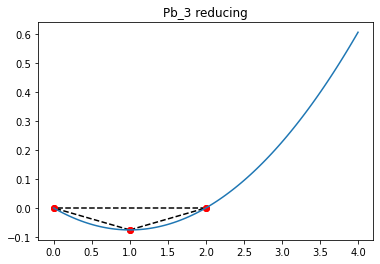

Bi3_red
La3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


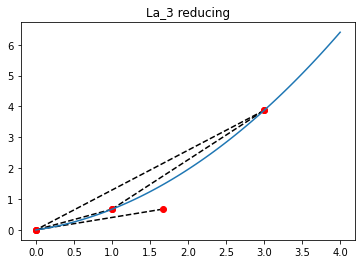

Ce3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


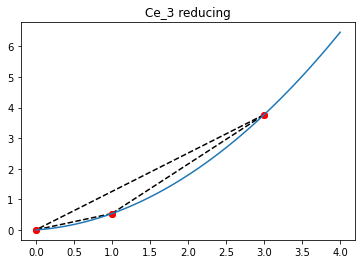

Nd3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


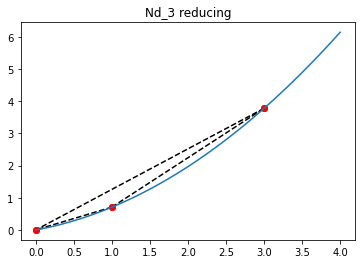

Pr3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


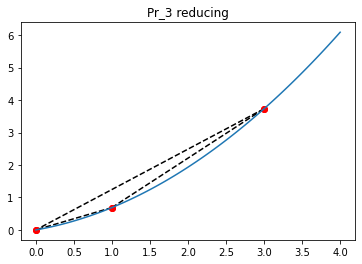

Sm3_red
Eu3_red


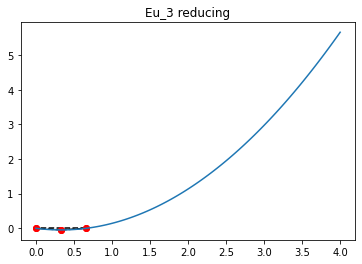

Gd3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


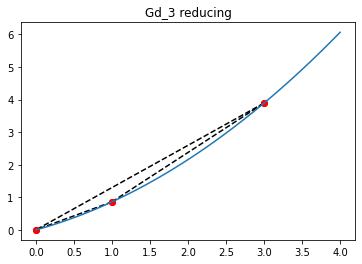

Tb3_red
Tb  odd.


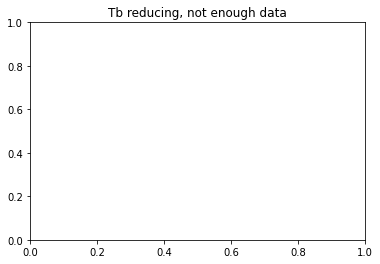

Dy3_red
Dy  odd.


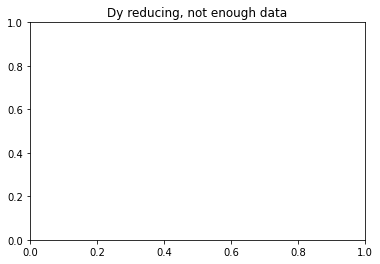

Ho3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


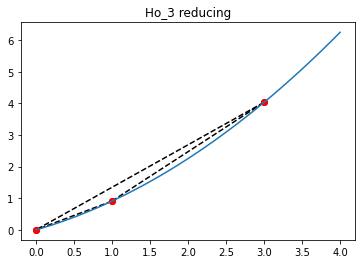

Er3_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


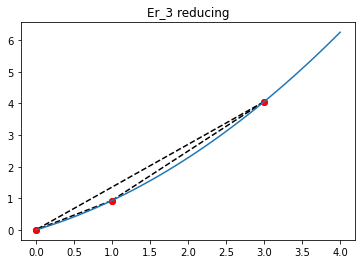

Tm3_red
Tm  odd.


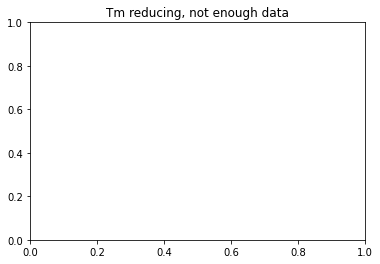

Yb3_red


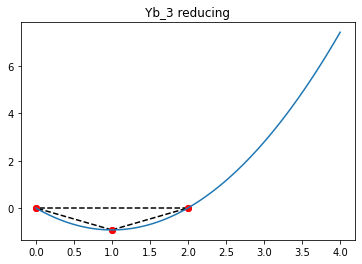

Lu3_red
Lu  odd.


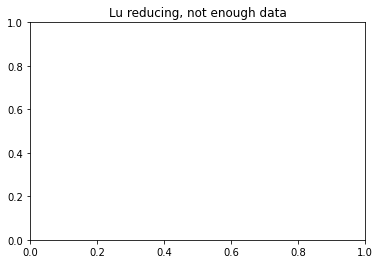

Si4_ox


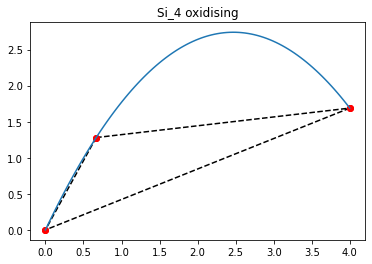

[-4.49054336e-01  2.21823449e+00 -2.05116020e-15]
Al4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


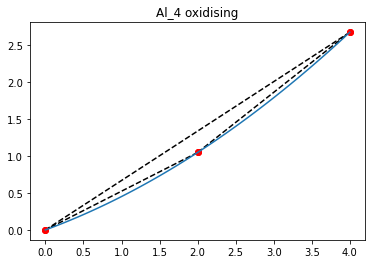

[ 7.22507641e-02  3.78465286e-01 -1.92296269e-16]
Ti4_ox


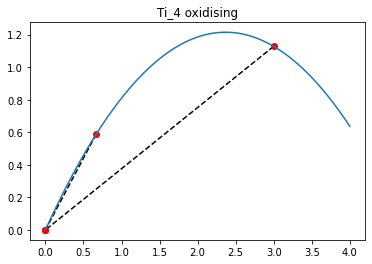

[-2.16738966e-01  1.02615233e+00  1.28197512e-16]
V4_ox


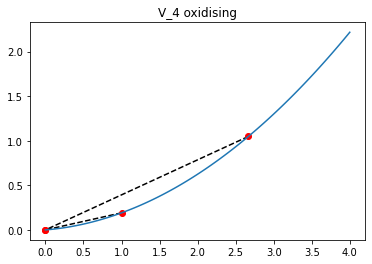

[1.20920235e-01 7.04816444e-02 9.61481343e-17]
Cr4_ox
None
Mn4_ox


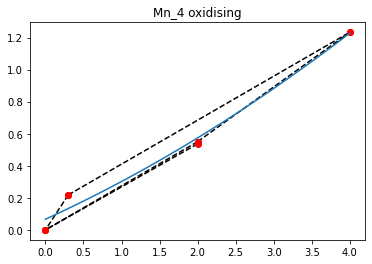

[0.01831011 0.21693724 0.06670608]
Fe4_ox


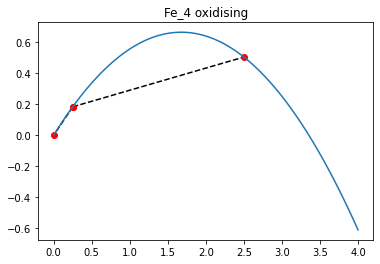

[-2.36434679e-01  7.92995235e-01 -1.28197512e-16]
Co4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Ni4_ox


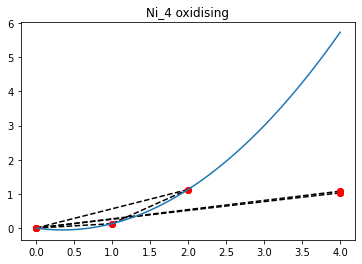

[ 4.34278730e-01 -3.04915129e-01  9.61481343e-17]
Cu4_ox
Cu  odd.


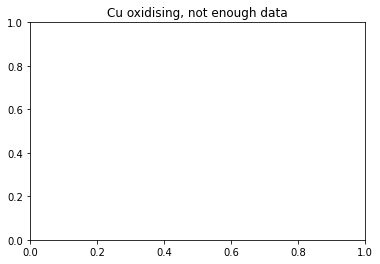

Nb4_ox


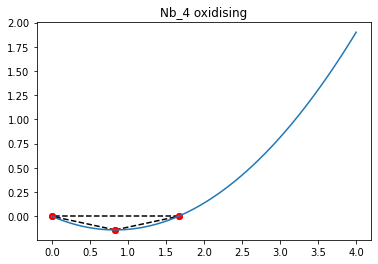

[ 2.03533174e-01 -3.39086268e-01  6.40987562e-17]
Mo4_ox


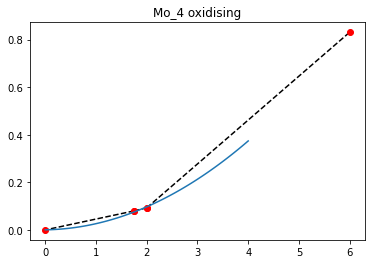

[0.02250735 0.00337672 0.00041679]
Li4_ox


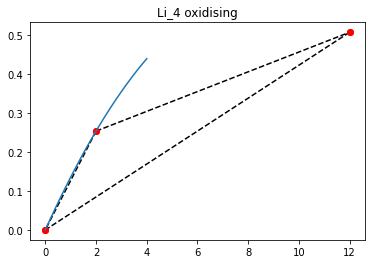

[-8.45218613e-03  1.43723971e-01 -6.40987562e-17]
Be4_ox
Be  odd.


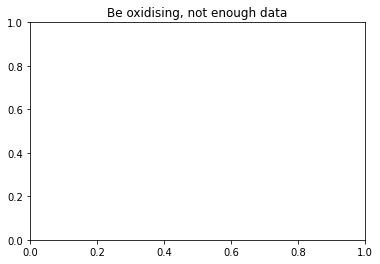

Na4_ox
None
Mg4_ox
Mg  odd.


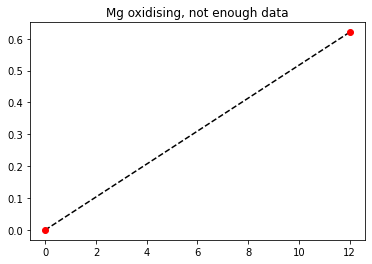

K4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


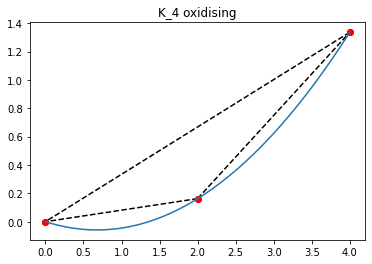

[ 1.26390689e-01 -1.71448155e-01  2.24345647e-16]
Ca4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Rb4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


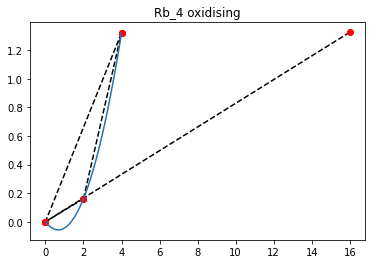

[ 1.24842262e-01 -1.68977151e-01  3.20493781e-17]
Sr4_ox
None
Cs4_ox
Cs  odd.


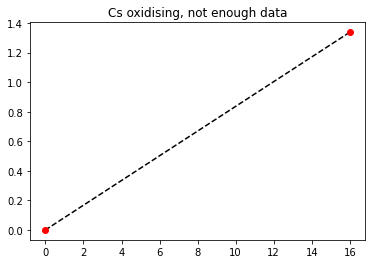

Ba4_ox


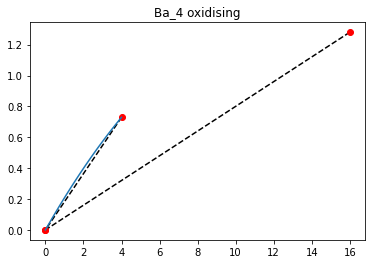

[-8.51819673e-03  2.16299159e-01  5.12790050e-16]
Sc4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


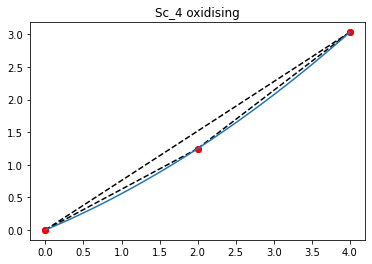

[ 6.72924586e-02  4.89240693e-01 -2.56395025e-16]
Zn4_ox
Zn  odd.


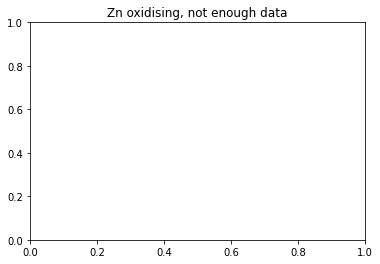

Ga4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


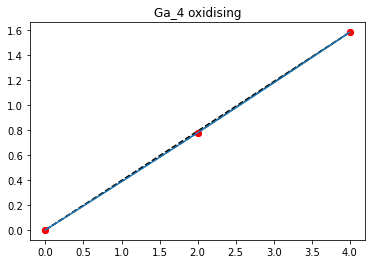

[ 3.28836839e-03  3.81806491e-01 -1.92296269e-16]
Ge4_ox


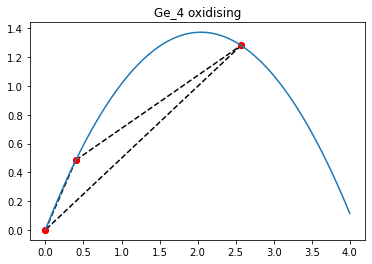

[-3.28826900e-01  1.34381347e+00  2.56395025e-16]
As4_ox


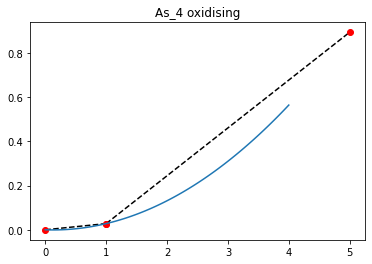

[ 3.76924524e-02 -9.73554323e-03 -8.41296175e-17]
Se4_ox


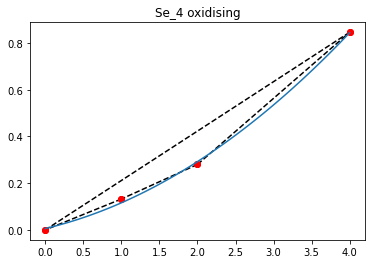

[0.03316928 0.0768382  0.00606056]
Br4_ox


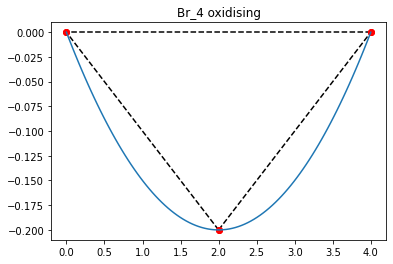

[ 5.00336797e-02 -2.00134719e-01  1.28197512e-16]
Y4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


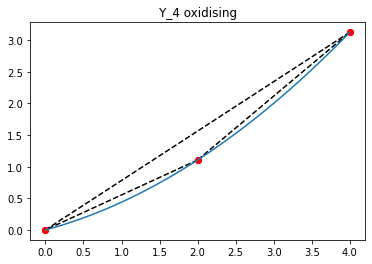

[1.14226103e-01 3.24474395e-01 6.40987562e-17]
Zr4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


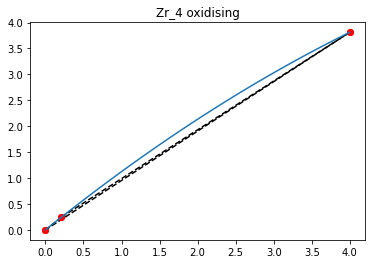

[-5.69454864e-02  1.18084562e+00  2.56395025e-16]
Tc4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


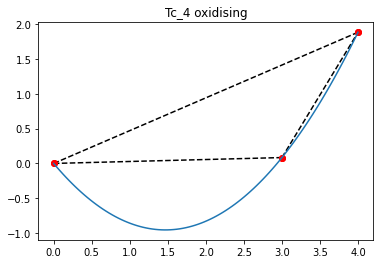

[ 4.42395604e-01 -1.29907964e+00  1.02558010e-15]
Ru4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Rh4_ox
Rh  odd.


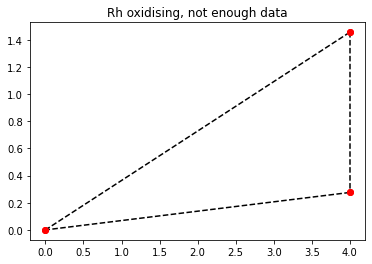

Pd4_ox
Pd  odd.


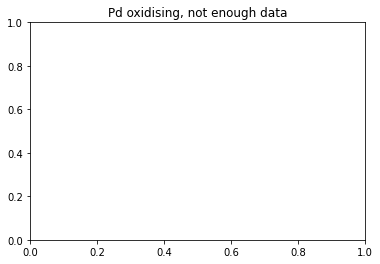

Ag4_ox
Ag  odd.


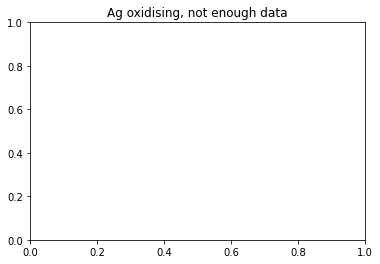

Cd4_ox
Cd  odd.


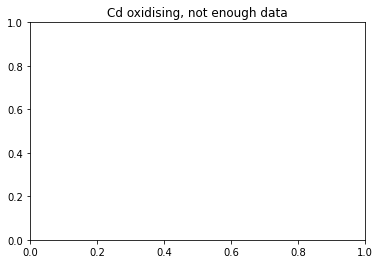

In4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


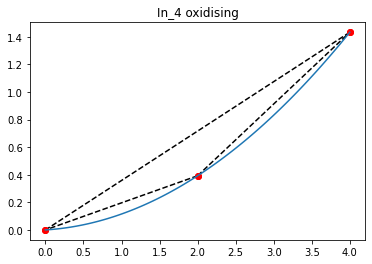

[8.09745107e-02 3.42564763e-02 6.40987562e-17]
Sn4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


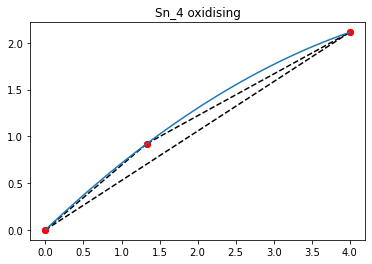

[-6.12778783e-02  7.73069941e-01  2.56395025e-16]
Sb4_ox


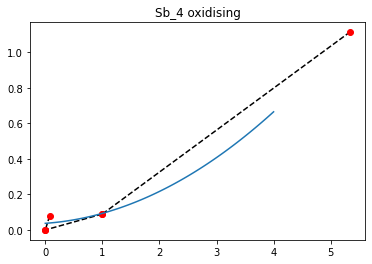

[0.03361211 0.02266978 0.0371253 ]
Te4_ox


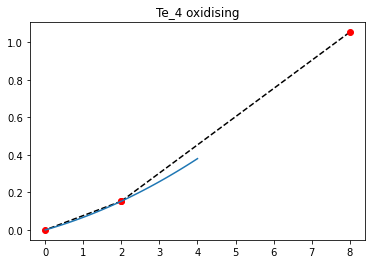

[ 9.17542079e-03  5.82463859e-02 -3.20493781e-17]
I4_ox


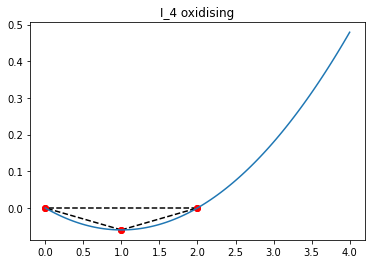

[ 5.98910751e-02 -1.19782150e-01  4.80740672e-17]
Hf4_ox
Hf  odd.


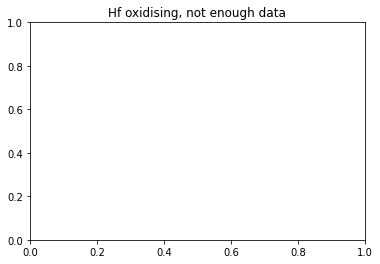

Ta4_ox


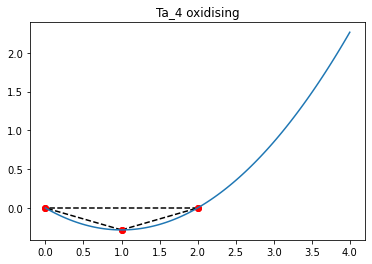

[ 2.83081136e-01 -5.66162273e-01  2.56395025e-16]
W4_ox


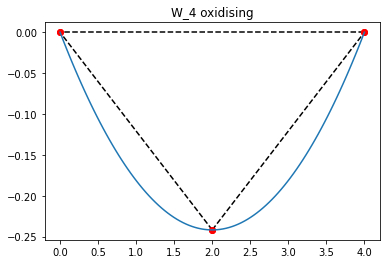

[ 6.04640866e-02 -2.41856346e-01  1.28197512e-16]
Re4_ox


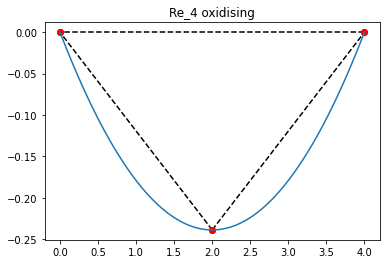

[ 5.97017553e-02 -2.38807021e-01  1.28197512e-16]
Os4_ox


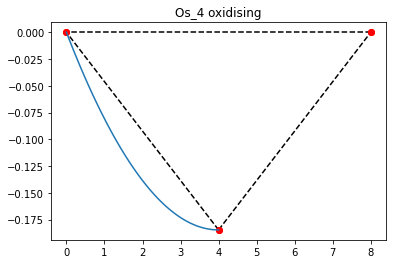

[ 1.15444258e-02 -9.23554065e-02  9.61481343e-17]
Ir4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


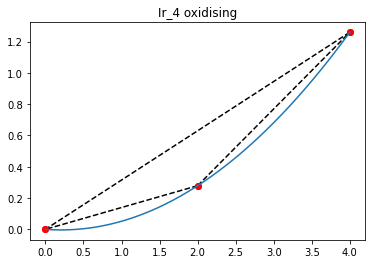

[ 8.77254697e-02 -3.60181875e-02  1.04160479e-16]
Pt4_ox
None
Au4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Au  odd.


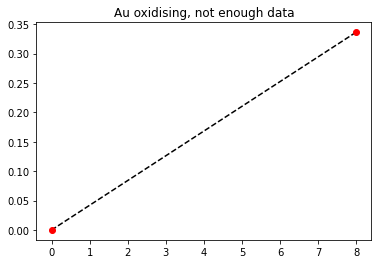

Hg4_ox
Hg  odd.


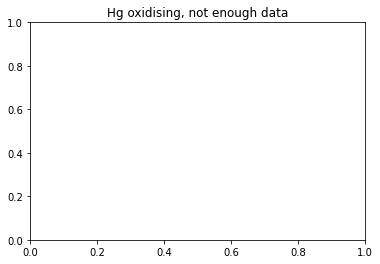

Tl4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Tl  odd.


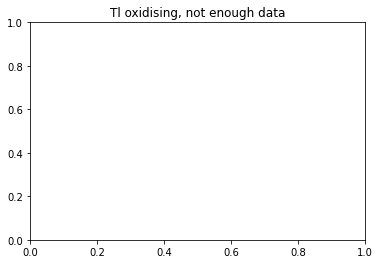

Pb4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


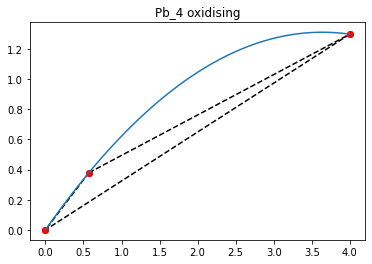

[-9.90834194e-02  7.20909055e-01 -5.12790050e-16]
Bi4_ox
None
La4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


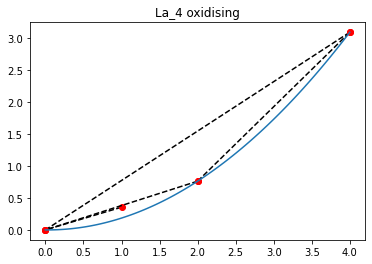

[ 1.95733614e-01 -1.07974625e-02  2.50385766e-16]
Ce4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


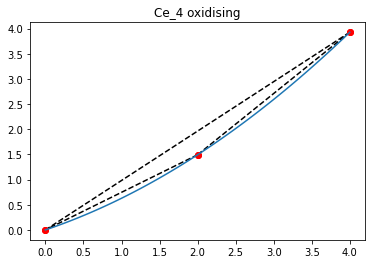

[ 1.17578003e-01  5.11343620e-01 -3.84592537e-16]
Nd4_ox
None
Pr4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


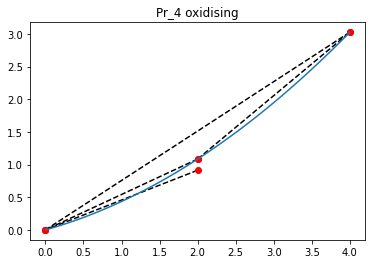

[ 1.07078240e-01  3.27766338e-01 -3.20493781e-16]
Sm4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


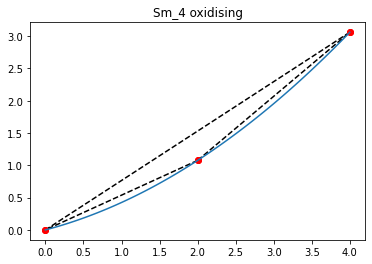

[ 1.13537565e-01  3.11145008e-01 -1.92296269e-16]
Eu4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


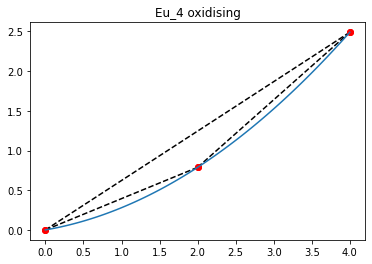

[ 1.14199722e-01  1.65593060e-01 -6.40987562e-17]
Gd4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


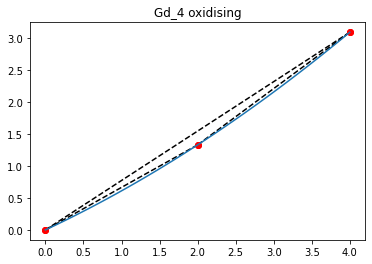

[ 5.40615397e-02  5.58064165e-01 -3.84592537e-16]
Tb4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


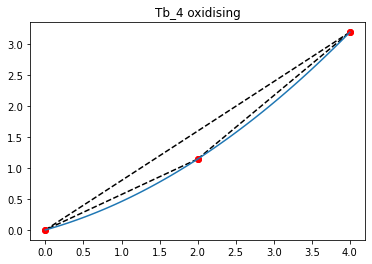

[ 1.12777757e-01  3.45508358e-01 -2.56395025e-16]
Dy4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


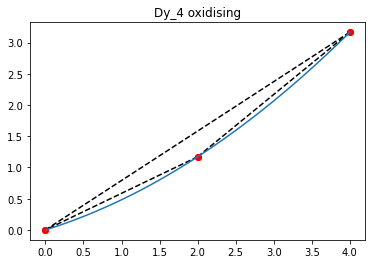

[ 1.02943294e-01  3.79901276e-01 -6.40987562e-17]
Ho4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


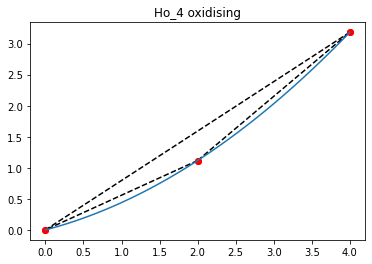

[ 1.18465584e-01  3.21708784e-01 -1.92296269e-16]
Er4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


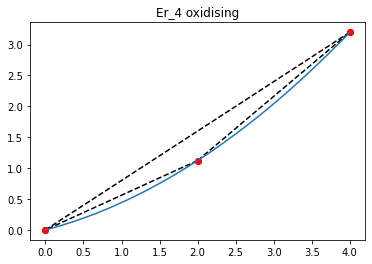

[ 1.19106576e-01  3.23190720e-01 -1.28197512e-16]
Tm4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


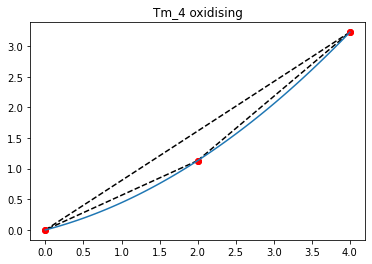

[1.20550800e-01 3.24202312e-01 1.28197512e-16]
Yb4_ox
None
Lu4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


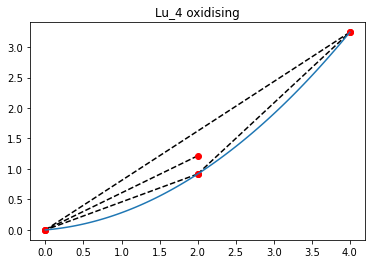

[ 1.76167012e-01  1.05966130e-01 -3.20493781e-17]
Si4_red
Al4_red


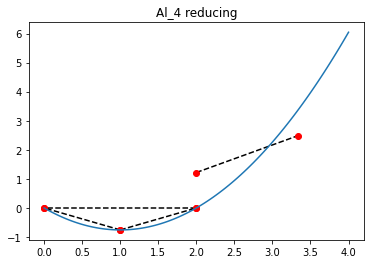

Ti4_red


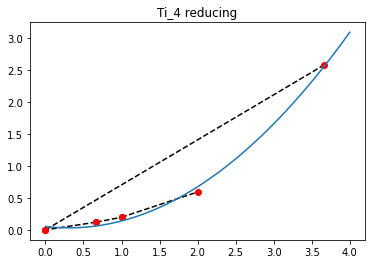

V4_red


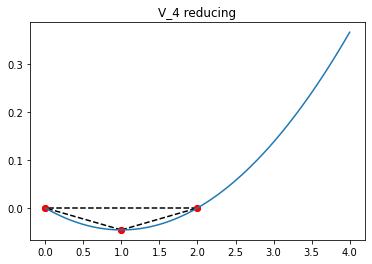

Cr4_red


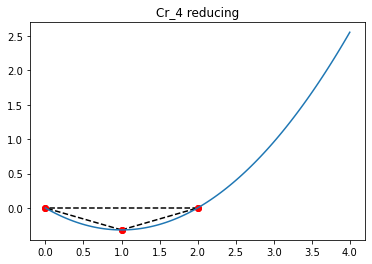

Mn4_red


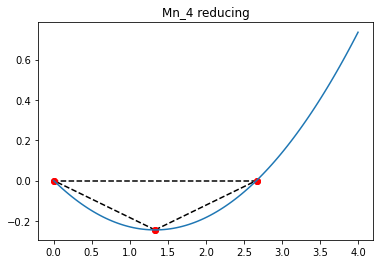

Fe4_red


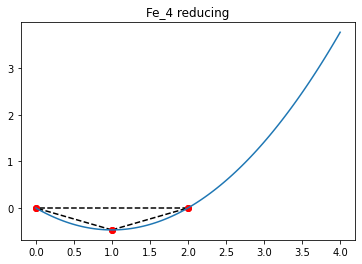

Co4_red


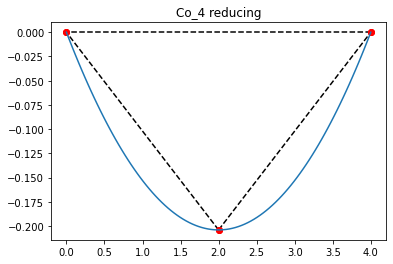

Ni4_red


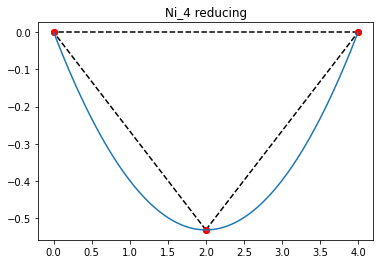

Cu4_red


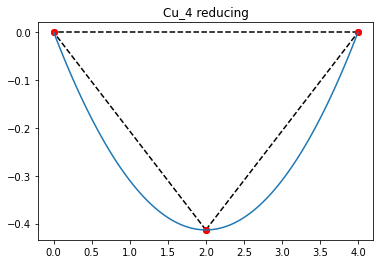

Nb4_red


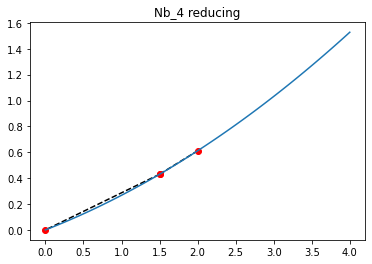

Mo4_red


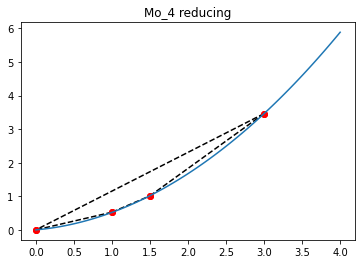

Li4_red


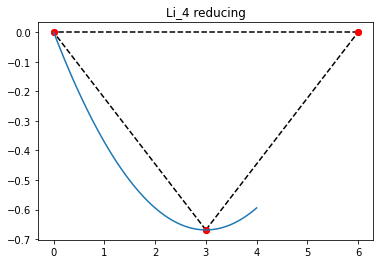

Be4_red


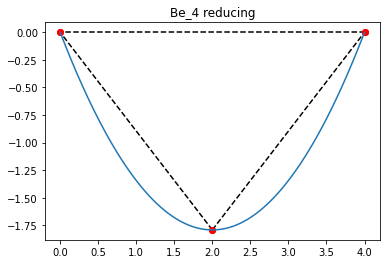

Na4_red


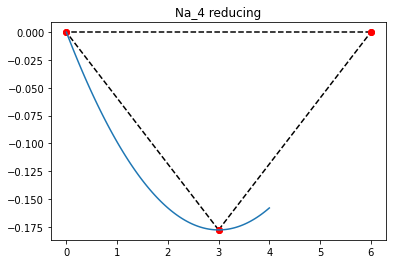

Mg4_red


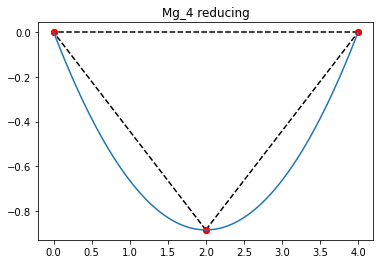

K4_red


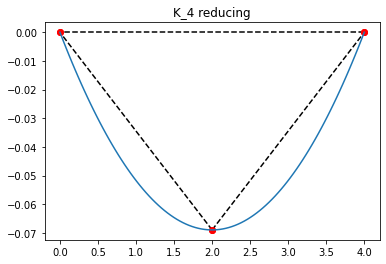

Ca4_red


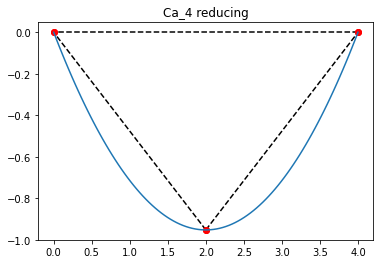

Rb4_red


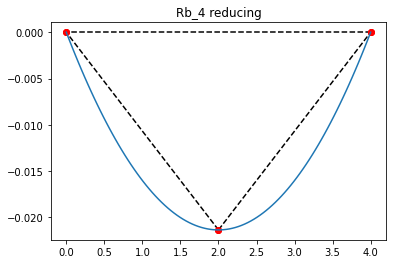

Sr4_red


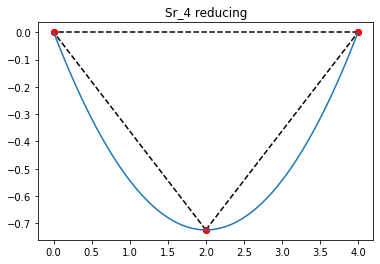

Cs4_red


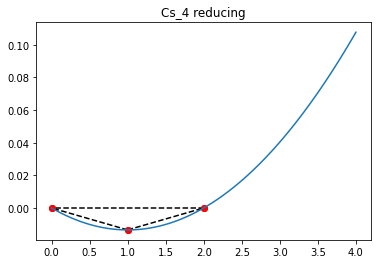

Ba4_red


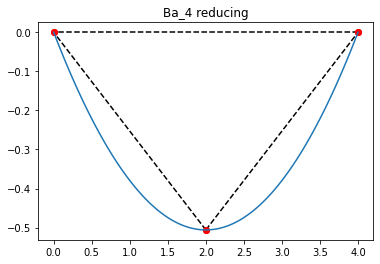

Sc4_red


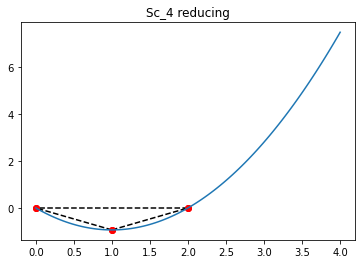

Zn4_red


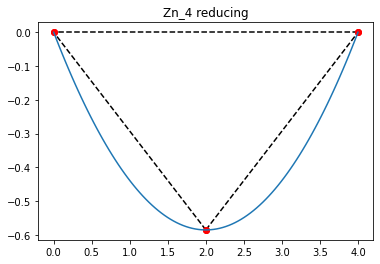

Ga4_red


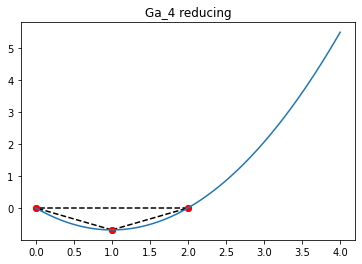

Ge4_red


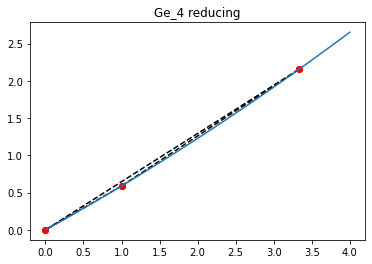

As4_red


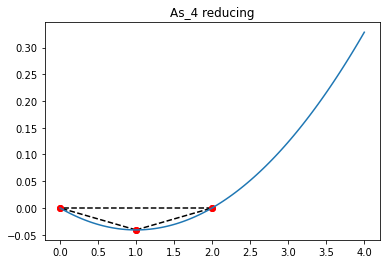

Se4_red
Se  odd.


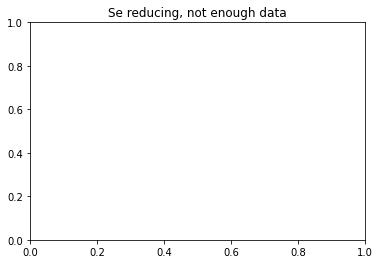

Br4_red


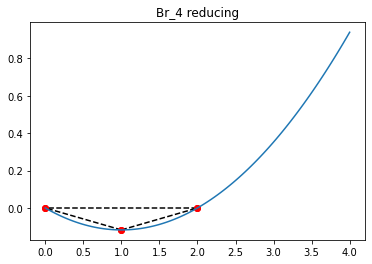

Y4_red


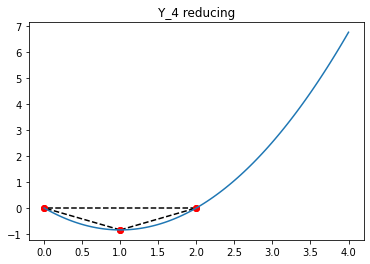

Zr4_red


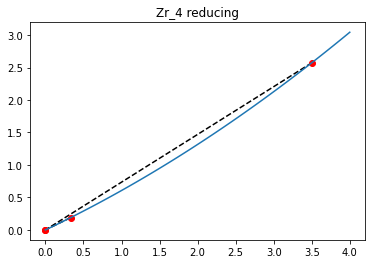

Tc4_red
Tc  odd.


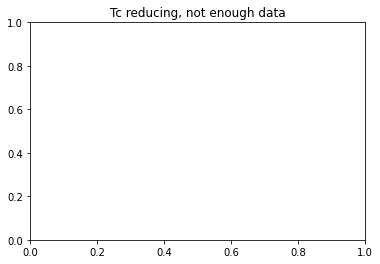

Ru4_red
Ru  odd.


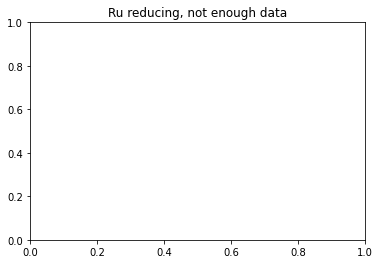

Rh4_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


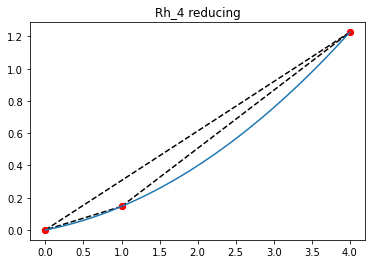

Pd4_red


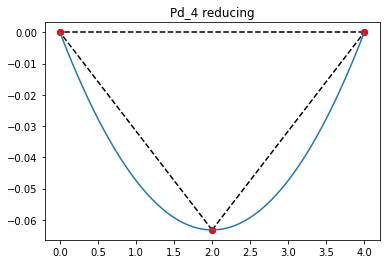

Ag4_red


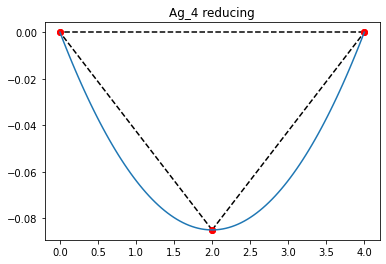

Cd4_red


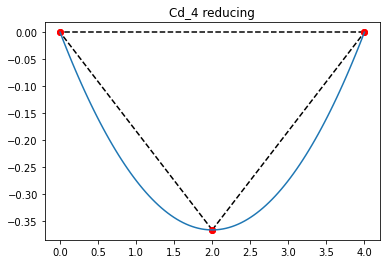

In4_red


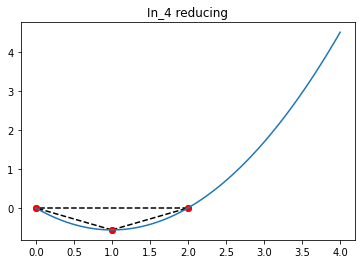

Sn4_red


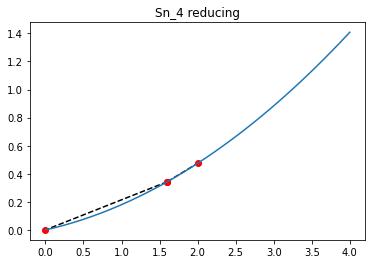

Sb4_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


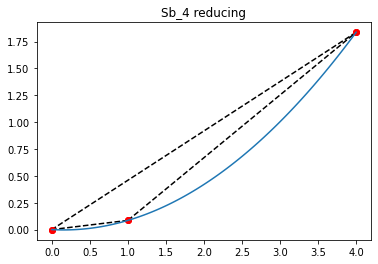

Te4_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
I4_red
I  odd.


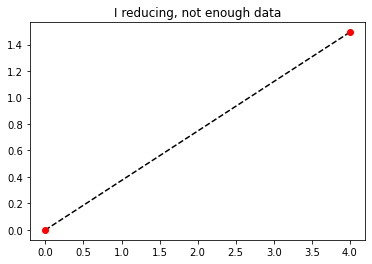

Hf4_red
Hf  odd.


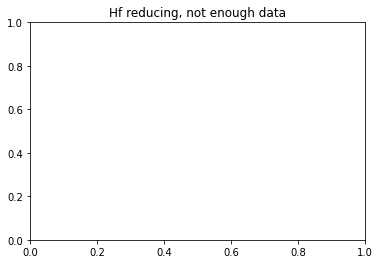

Ta4_red


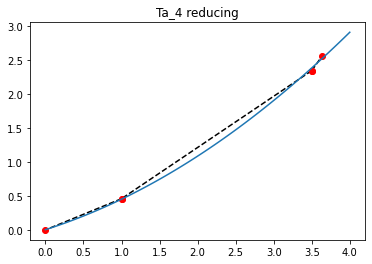

W4_red


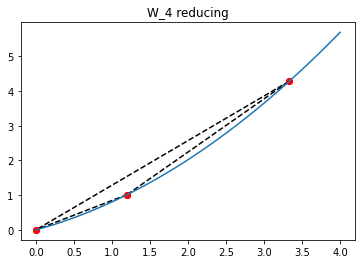

Re4_red
Re  odd.


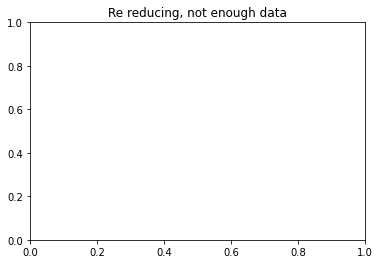

Os4_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Ir4_red
Ir  odd.


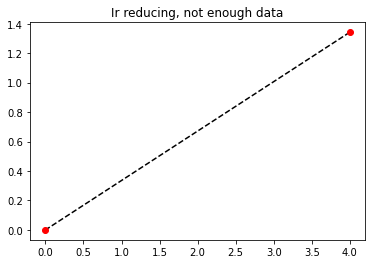

Pt4_red


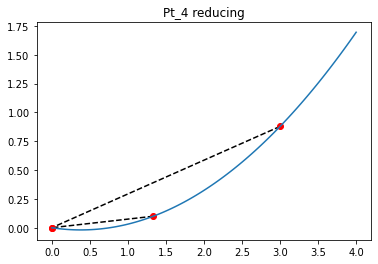

Au4_red


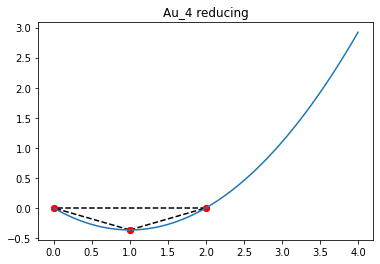

Hg4_red


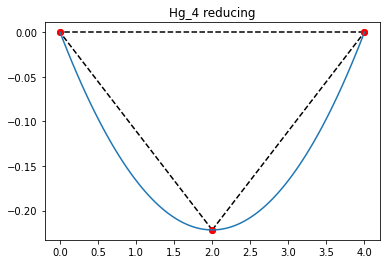

Tl4_red


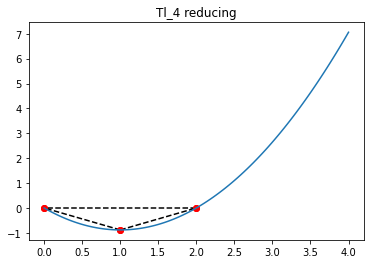

Pb4_red


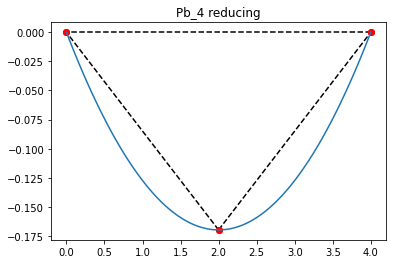

Bi4_red


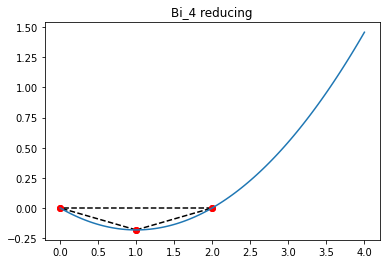

La4_red


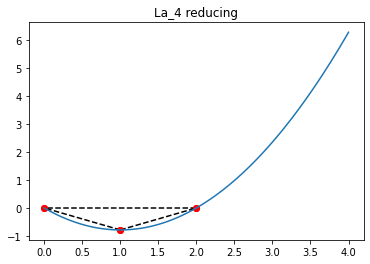

Ce4_red


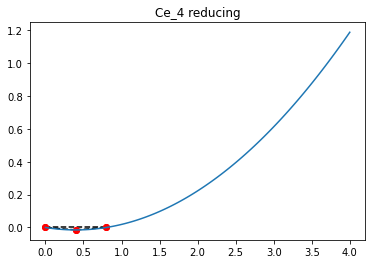

Nd4_red


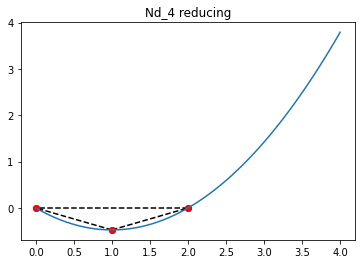

Pr4_red


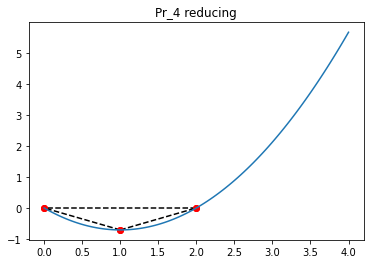

Sm4_red


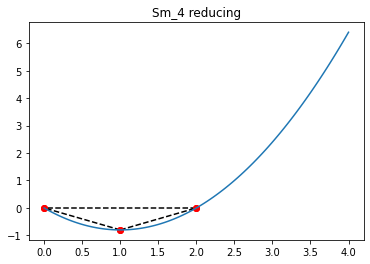

Eu4_red


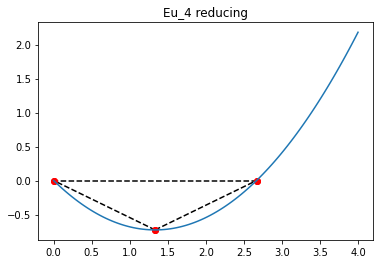

Gd4_red


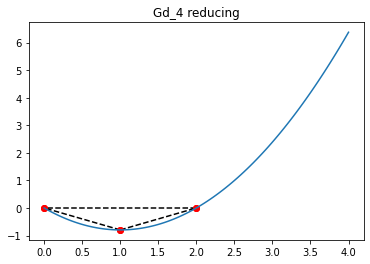

Tb4_red


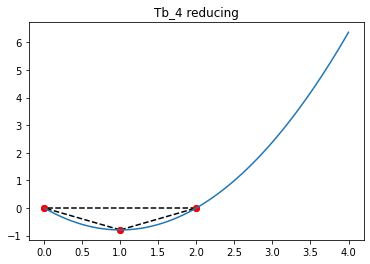

Dy4_red


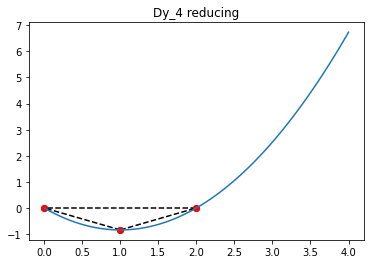

Ho4_red


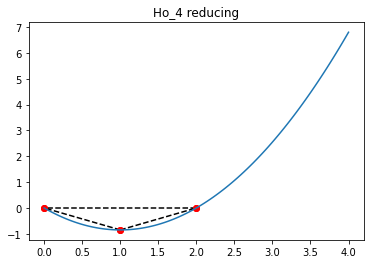

Er4_red


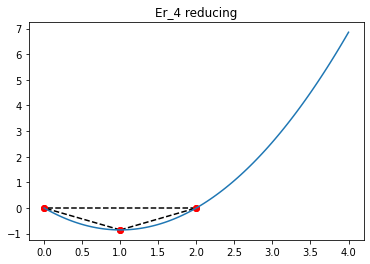

Tm4_red


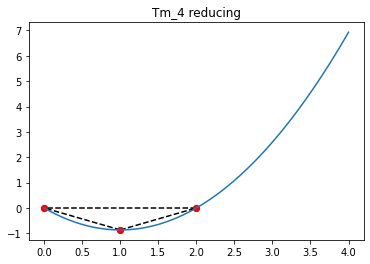

Yb4_red


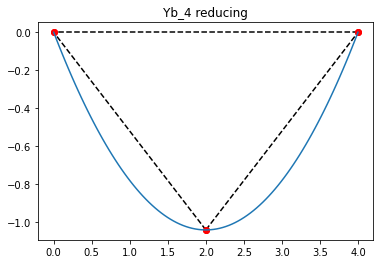

Lu4_red


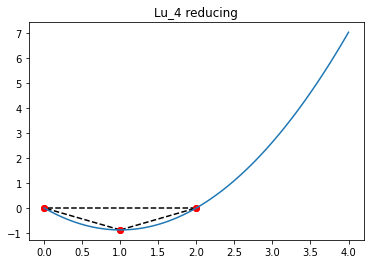

In [6]:
mp_quadratic_equations_ox = defaultdict()
mp_quadratic_equations_red = defaultdict()

for ox_iter in ox_states:
    for ele in unary_data.keys():
        print("{}{}_ox".format(ele, ox_iter))
        ox2low, form_ene = get_ox2lowest(ele, ele2mp[ox_iter][ele], ox_iter, oxidising=True)
        hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_iter, form_ene, ele, oxidising=True)
        if hull_ox2energy is None:
            mp_quadratic_equations_ox[ele+str(int(ox_iter))] = [0, -form_ene/(8-ox_iter),0]
            continue

        coeffs = get_quadratic(hull_ox2energy)
        print(coeffs)
        mp_quadratic_equations_ox[ele+str(int(ox_iter))] = coeffs
        if mp_quadratic_equations_ox[ele+str(int(ox_iter))] is None:
            mp_quadratic_equations_ox[ele+str(int(ox_iter))] = [0, -form_ene/(8-ox_iter), 0]

    for ele in unary_data.keys():
        print("{}{}_red".format(ele, ox_iter))
        ox2low, form_ene = get_ox2lowest(ele, ele2mp[ox_iter][ele], ox_iter, oxidising=False)

        hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_iter, form_ene, ele, oxidising=False)
        if hull_ox2energy is None:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = [0, -form_ene/ox_iter, 0]
            continue
        try:
            coeffs = get_quadratic(hull_ox2energy)
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = coeffs

        except TypeError:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = coeffs

        if mp_quadratic_equations_red[ele+str(int(ox_iter))] is None:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = [0, -form_ene/ox_iter, 0]

    for ele_ox in mp_quadratic_equations_red:
        if mp_quadratic_equations_red[ele_ox][0]<0:
            # cant have this curvature
            mp_quadratic_equations_red[ele_ox][0]=0
        if mp_quadratic_equations_ox[ele_ox][0]<0:
            mp_quadratic_equations_ox[ele_ox][0]=0
    

    

In the above plots, any time a line is fitted through points that means we have got coefficients by ordinary least squares. Many times there is not enough data to fit through, and in those cases we just take the parabola to be some linear function found by dividing the formation energy by an appropriate value depending on the oxidation state. In cases where the curve plotted is concave down, we set the first coefficient to 0.

```
if mp_quadratic_equations_red[ele_ox][0]<0:
    mp_quadratic_equations_red[ele_ox][0] = 0
```

A number of these parabolas we deem should not be shaped as they are to meet the criteria discussed in the paper that they should match the shape of the hull from the reference oxidation state, we list them here. You can check whether the plots yourself by doing a control+F of `Ni4_ox` for instance. This curve appears wrong since it supposes that Ni prefers 5+ to 4+ when this is likely just a facet of the large instability of the NiO2 entry.

Ni2_ox, Al2_red, Tl2_red, Bi2_red, Sr3_ox, Ag3_ox, Pd3_ox, Ni4_ox
we set by hand by inspecting Materials Project or OQMD

In [7]:
# take difference between the NiO formation energy (mp-19009) 
# and the NiO2 () formation energy and divide by 2 (supposed difference in oxidation state)
mp_quadratic_equations_ox['Ni2'] = [0, 	(1.218-0.687)/2, 0]
# take difference in formation energy between AlO (mp-8023) and Al2O (mp-8022)
mp_quadratic_equations_red['Al2'] = [0, 1.555-0.139, 0]
# plotting Tl-O phase diagram we can see the TlO entry is high off the hull
# set to 1/2, as -1 is approximately the value at the hull for this conc of Tl:O
mp_quadratic_equations_red['Tl2'] = [0, 0.5, 0]
# plotting Bi-O phase diagram we can see the BiO entry is high off the hull
# set to 1.4/2, as -1.4 is approximately the value at the hull for this conc of Tl:O
mp_quadratic_equations_red['Bi2'] = [0, 0.7, 0]
# plotting Sr-O phase diagram we can see the Sr2O3 entry is high off the hull
# we set to same as the SrO2 oxidising parabola
mp_quadratic_equations_ox['Sr3'] = mp_quadratic_equations_ox['Sr4']
# take diff in formation energy between mp-546190 and mp-1214946
mp_quadratic_equations_ox['Ag3'] = [0, (0.359-0.01),0]
# fit by hand
mp_quadratic_equations_ox['Pd3'] = list(np.polyfit([0, 1, 4], [0, 0.05, 0.74], 2))
# we arrive at this value by taking the energy difference between NiO2 and Ni2O5
# mp-35925 and mp-1094139 respectively
mp_quadratic_equations_ox['Ni4'] = [0, 0.5, 0]



Lastly, some fitting lead to very low coefficients due to the instability of the reference oxide, this is the case for 
Ag4_ox, Au4_ox and Br4_ox

In [8]:
# match slope of the lower ox state oxide
mp_quadratic_equations_ox['Ag4'] = mp_quadratic_equations_ox['Ag3']
# match slope of the lower ox state oxide
mp_quadratic_equations_ox['Au4'] = mp_quadratic_equations_ox['Au3']
# point on hull for BrO2 conc is roughly 0.17, so divide this by 4
mp_quadratic_equations_ox['Br4'] = [0, 0.17/4, 0]


### Printing parabola coefficients for spreadsheet

In [9]:
for ox_iter in ox_states:
    print(ox_iter)
    for ele in unary_data.keys():
        print(ele, end=", ")
        print("{:.4f}".format(mp_quadratic_equations_ox[ele+str(int(ox_iter))][0]), end=", ")
        print("{:.4f}".format(mp_quadratic_equations_ox[ele+str(int(ox_iter))][1]), end=", ")
        print("{:.4f}".format(mp_quadratic_equations_red[ele+str(int(ox_iter))][0]), end=", ")
        print("{:.4f}".format(mp_quadratic_equations_red[ele+str(int(ox_iter))][1]))


2
Si, 0.3048, -1.2194, 0.0000, 1.0235
Al, 1.8742, -3.7485, 0.0000, 1.4160
Ti, 0.1483, -0.5933, 0.4256, 0.4244
V, 0.4352, -0.8705, 0.0000, 1.0450
Cr, 0.3993, -0.7986, 0.0000, 0.9830
Mn, 0.1596, -0.2130, 0.0000, 0.9892
Fe, 0.2253, -0.4506, 0.0000, 0.7404
Co, 0.0261, 0.0512, 0.0000, 0.6417
Ni, 0.0000, 0.2655, 0.2809, 1.0692
Cu, 0.0965, 0.0138, 0.0000, 0.4709
Nb, 0.0938, -0.5314, 0.0000, 1.1424
Mo, 0.2520, -1.0079, 0.0000, 0.5039
Li, 0.0000, 0.1935, 0.3008, -0.6015
Be, 0.0000, 0.5170, 0.0000, 1.5509
Na, 0.0000, 0.2371, 0.0217, -0.0435
Mg, 0.0000, 0.5090, 0.0000, 1.5269
K, 0.0117, 0.0111, 0.5445, -0.3862
Ca, 0.0000, 0.9553, 0.0000, 1.6539
Rb, 0.0165, -0.0210, 0.4671, -0.2566
Sr, 0.0000, 1.1879, 0.0000, 1.5380
Cs, 0.0022, -0.0044, 0.5058, -0.3531
Ba, 0.0000, 0.2721, 0.0000, 1.4113
Sc, 0.7280, -1.4561, 0.0000, 1.6197
Zn, 0.0000, 0.2983, 0.0000, 0.8950
Ga, 0.8840, -1.7680, 0.0000, 0.6919
Ge, 0.2597, -1.0388, 0.0000, 0.5194
As, 1.0854, -2.1708, 0.0000, 0.2714
Se, 0.1441, -0.5764, 0.0000, 0.2882